## Load & Preprocess MSWEP Data

In [1]:
# type: ignore
import sys
import h5py
import os
import shutil
import keras
import gc
import time
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pathlib import Path
from sklearn.metrics import r2_score
from tensorflow.keras import layers, models
from keras.utils import plot_model
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from myLibrary import inversTransform, inverseLogTransform, image2Xarray, selectPrecipitation

# Define all parameters
datasetsName    = 'JI_N_025_01'
modelName       = 'EDSR'
inputResolution = 'I025-Conv2D'
ReportFolder    = modelName + "_" + datasetsName + "_" + inputResolution
Normalized      = True
DoPreProcessing = False
learningRate    = 1e-4
batch_size      = 32
numEpochs       = 100

In [2]:
# Path Define
# Get the absolute path 
pathNow = Path().parent.absolute() #See @Arminius answer
pathNow = pathNow.parent
print(pathNow)

# Define the base directory where MSWEP files are stored
datasetsDir     = pathNow / 'Rifqi.Code' / 'Datasets' / datasetsName 

# Define HDF5 file name
hdf5Training    = datasetsDir / "mswepTrain.h5"
hdf5Validation  = datasetsDir / "mswepValidation.h5"
hdf5Testing     = datasetsDir / "mswepTesting.h5"
print(hdf5Training)

# Report Filename
ReportFolder    = str(pathNow) + "\\Rifqi.Code\\" + "\\Reports\\" + ReportFolder
#Create folder and delete if exists
if os.path.exists(ReportFolder):
    shutil.rmtree(ReportFolder)
os.makedirs(ReportFolder) 
os.makedirs(ReportFolder + '/Graph') 

plotModel       = ReportFolder + '/' + 'Model.png'
fileNameModel   = ReportFolder + '/' + 'CallbacksModel.keras'
fileNameReport  = ReportFolder + '/' + 'Report.csv'
fileNameHist    = ReportFolder + '/' + 'Histogram.csv'
fileNameLog     = ReportFolder + '/' + 'TrainingLog.txt'
fileNamePKL     = ReportFolder + '/' + 'History.pkl'
fileNameCSVLogger = ReportFolder + '/' + 'CSVLogger.csv'
print(ReportFolder)

c:\Users\rifqi\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection
c:\Users\rifqi\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Rifqi.Code\Datasets\JI_N_025_01\mswepTrain.h5
c:\Users\rifqi\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Rifqi.Code\\Reports\EDSR_JI_N_025_01_I025-Conv2D


In [3]:
with h5py.File(hdf5Training, "r") as hf:
    precipTrainOriginal = hf["precipTrainOriginal"][:]
    precipLowResTrain   = hf["precipLowResTrain"][:]
    precipHighResTrain  = hf["precipHighResTrain"][:]
    
    timeOriginalTrain   = hf["timeOriginalTrain"][:]
    timeHighResTrain    = hf["timeHighResTrain"][:]
    timeLowResTrain     = hf["timeLowResTrain"][:]
    
    latOriginal         = hf["latOriginal"][:]
    lonOriginal         = hf["lonOriginal"][:]
    latLowRes           = hf["latLowRes"][:]
    lonLowRes           = hf["lonLowRes"][:]
    latHighRes          = hf["latHighRes"][:]
    lonHighRes          = hf["lonHighRes"][:]
    
    if Normalized:  
        scale_          = hf["scale_"][:]           # Loading Min Max Scaler Parameter
        min_            = hf["min_"][:]
        data_min_       = hf["data_min_"][:]
        data_max_       = hf["data_max_"][:]
        feature_range   = hf["feature_range"][:]        
    print("Loaded Original Train Data Shape:", precipHighResTrain.shape)

with h5py.File(hdf5Validation, "r") as hf:
    precipValOriginal   = hf["precipValOriginal"][:]
    precipLowResVal     = hf["precipLowResVal"][:]
    precipHighResVal    = hf["precipHighResVal"][:]
    
    timeOriginalVal     = hf["timeOriginalVal"][:]
    timeHighResVal      = hf["timeHighResVal"][:]
    timeLowResVal       = hf["timeLowResVal"][:]
    
    print("Loaded Original Validation Data Shape:", precipHighResVal.shape)
    
with h5py.File(hdf5Testing, "r") as hf:
    precipTestOriginal  = hf["precipTestOriginal"][:]
    precipLowResTest    = hf["precipLowResTest"][:]
    precipHighResTest   = hf["precipHighResTest"][:]
    
    timeOriginalTest    = hf["timeOriginalTest"][:]
    timeHighResTest     = hf["timeHighResTest"][:]
    timeLowResTest      = hf["timeLowResTest"][:]
    
    print("Loaded Original Test Data Shape:", precipHighResTest.shape)   

Loaded Original Train Data Shape: (5113, 35, 100, 1)
Loaded Original Validation Data Shape: (1096, 35, 100, 1)
Loaded Original Test Data Shape: (1096, 35, 100, 1)


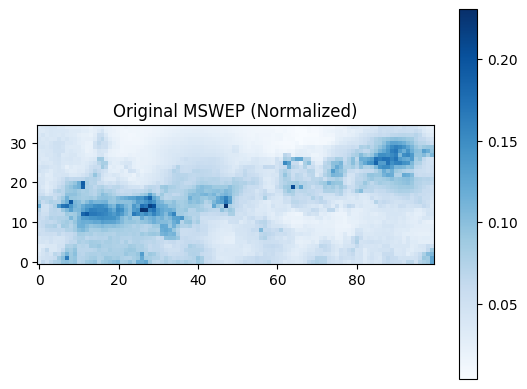

In [4]:
showImage = precipTrainOriginal[50, :, :, 0]

plt.imshow(showImage, cmap="Blues", origin="lower")
plt.title("Original MSWEP (Normalized)")
plt.colorbar()
plt.show()

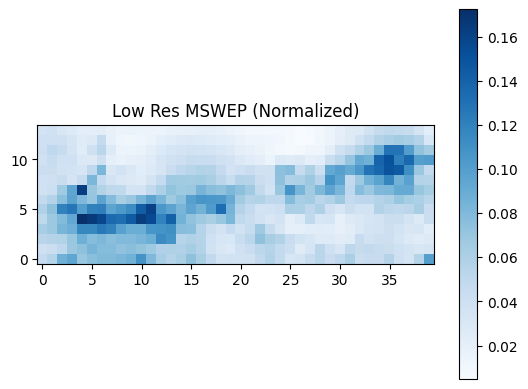

In [5]:
showImage = precipLowResTrain[50, :, :, 0]

plt.imshow(showImage, cmap="Blues", origin="lower")
plt.title("Low Res MSWEP (Normalized)")
plt.colorbar()
plt.show()

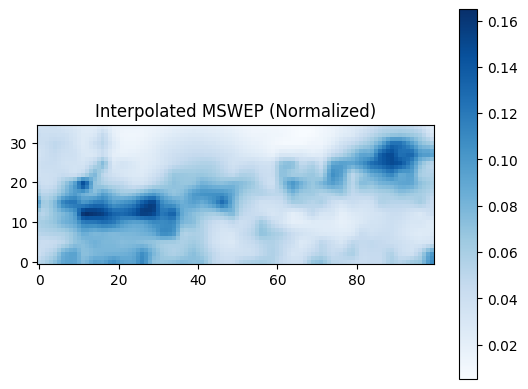

In [6]:
showImage = precipHighResTrain[50, :, :, 0]

plt.imshow(showImage, cmap="Blues", origin="lower")
plt.title("Interpolated MSWEP (Normalized)")
plt.colorbar()
plt.show()

In [7]:
# # Custom Loss Function: MAE + Weighted Extreme Event Loss
# def MAE_Extreme_Loss(weight=2.0, threshold=0.1):
#     """
#     weight    : bobot penalty untuk data ekstrem
#     threshold : batas nilai untuk menganggap data itu 'extreme' (misal curah hujan > 0.1)

#     """
#     def loss(y_true, y_pred):
#         # Basic MAE untuk seluruh data
#         mae_all = K.mean(K.abs(y_true - y_pred))

#         # Cari lokasi data ekstrem (masking)
#         mask_extreme = K.cast(K.greater_equal(y_true, threshold), dtype=tf.float32)

#         # Hitung MAE khusus data ekstrem
#         extreme_true = y_true * mask_extreme
#         extreme_pred = y_pred * mask_extreme
#         mae_extreme = K.sum(K.abs(extreme_true - extreme_pred)) / (K.sum(mask_extreme) + K.epsilon())

#         # Total Loss = MAE Normal + Weight * MAE Extreme
#         total_loss = mae_all + weight * mae_extreme

#         return total_loss

#     return loss

In [8]:
def roundDecimal(number, decimal_places):
    multiplier = 10 ** decimal_places
    return math.ceil(number * multiplier) / multiplier

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def KGE(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    # Mean dan Std
    mean_obs = tf.reduce_mean(y_true)
    mean_sim = tf.reduce_mean(y_pred)
    
    std_obs = tf.math.reduce_std(y_true)
    std_sim = tf.math.reduce_std(y_pred)
    
    # Korelasi Pearson manual
    r_num = tf.reduce_sum((y_true - mean_obs) * (y_pred - mean_sim))
    r_den = tf.sqrt(tf.reduce_sum((y_true - mean_obs)**2) * tf.reduce_sum((y_pred - mean_sim)**2))
    r = r_num / (r_den + 1e-6)

    # Komponen KGE
    alpha = std_sim / (std_obs + 1e-6)
    beta = mean_sim / (mean_obs + 1e-6)
    
    # KGE formula
    kge = 1 - tf.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

# Custom R² loss function
def RSquare(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))           # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))   # Total sum of squares
    return 1 - (ss_res / (ss_tot + K.epsilon()))            # 1 - R² (to minimize)

target_h, target_w = precipHighResTrain.shape[1:3]  # assuming shape: (samples, height, width, 1)
target_shape = (target_h, target_w)

def createEDSR(input_shape=(14, 40, 1), target_shape=(35, 100)):
    inputs = layers.Input(shape=input_shape)

    # Initial conv layer
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)

    # 19 Residual blocks
    for _ in range(19):
        res = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
        res = layers.Conv2D(64, (3, 3), padding="same")(res)
        x = layers.Add()([x, res])

    # Trainable upsampling (2×)
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)  # 14→28, 40→80

    # Resize to target (35, 100)
    x = layers.Lambda(lambda img: tf.image.resize(img, size=target_shape, method='bilinear'))(x)

    # Output layer
    output = layers.Conv2D(1, (3, 3), padding="same", activation="linear")(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    return model

In [9]:
input_shape     = (precipLowResTrain.shape[1], precipLowResTrain.shape[2], 1)
modelEDSR       = createEDSR(input_shape, target_shape)

plot_model(modelEDSR, to_file=plotModel, show_shapes=True, show_layer_names=True)
print(modelEDSR.summary())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 40, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 40, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 40, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 4

In [10]:
print("Loaded Original Train Data Shape:", precipTrainOriginal.shape)
print("Loaded Original Train Data Shape:", precipLowResTrain.shape)
print("Loaded Original Train Data Shape:", precipHighResTrain.shape)

Loaded Original Train Data Shape: (5113, 35, 100, 1)
Loaded Original Train Data Shape: (5113, 14, 40, 1)
Loaded Original Train Data Shape: (5113, 35, 100, 1)


In [11]:
lossHuber       = keras.losses.Huber(delta=1.0, reduction="sum_over_batch_size", name="huber_loss")
lossCosine      = keras.losses.CosineSimilarity(axis=-1, reduction="sum_over_batch_size", name="cosine_similarity")
lossMAE         = keras.losses.MeanAbsoluteError()
lossMSE         = keras.losses.MeanSquaredError()
lossMAPE        = keras.losses.MeanAbsolutePercentageError()

metricsRMSE     = keras.metrics.RootMeanSquaredError()
metricsMSE     = keras.metrics.MeanSquaredError()
metricsMAE      = keras.metrics.MeanAbsoluteError()

# Setup the model
opt         = keras.optimizers.Adam(learning_rate=learningRate)
# opt         = keras.optimizers.SGD(learning_rate=learningRate)
modelEDSR.compile(optimizer=opt,
                  loss=lossMSE, 
                  metrics=[SSIM, PSNR, KGE] 
                  )

checkpoint  = keras.callbacks.ModelCheckpoint(fileNameModel, save_best_only=True, monitor='val_PSNR', verbose=1, mode='max')
plateau     = keras.callbacks.ReduceLROnPlateau(monitor='val_PSNR', factor=0.5, patience=5, min_lr = 1e-7, mode='max')
csv_logger = tf.keras.callbacks.CSVLogger(fileNameCSVLogger)

# Training
keras.backend.clear_session()
gc.collect()
print("Fit model on training data - " + modelName)
start_time = time.monotonic()

Fit model on training data - EDSR


In [12]:
class TeeLogger:
    def __init__(self, *files):
        self.files = files

    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush()  # Ensure it's written immediately

    def flush(self):
        for f in self.files:
            f.flush()

In [13]:
log_file = open(fileNameLog, 'w')
tee = TeeLogger(sys.stdout, log_file)
original_stdout = sys.stdout
sys.stdout = tee

history = modelEDSR.fit(
    precipLowResTrain,
    precipTrainOriginal,
    batch_size = batch_size,
    epochs = numEpochs,
    validation_data = (precipLowResVal, precipValOriginal),
    callbacks = [checkpoint, plateau, csv_logger],
    verbose = 1
)

# Restore original stdout
sys.stdout = original_stdout
log_file.close()

diffTime = time.monotonic() - start_time
hours   = int(diffTime // 3600)
minutes = int((diffTime % 3600) // 60)
seconds = int(diffTime % 60)

print(f"Training Time: {hours}h {minutes}m {seconds}s")
print("Training log saved to:", fileNameLog)

Epoch 1/100
160/160 [==============================] - ETA: 0s - loss: 1.0879e-04 - SSIM: 0.9314 - PSNR: 44.2684 - KGE: 0.8826
Epoch 1: val_PSNR improved from -inf to 48.04983, saving model to c:\Users\rifqi\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Rifqi.Code\\Reports\EDSR_JI_N_025_01_I025-Conv2D\CallbacksModel.keras
160/160 [==============================] - 19s 78ms/step - loss: 1.0879e-04 - SSIM: 0.9314 - PSNR: 44.2684 - KGE: 0.8826 - val_loss: 4.1709e-05 - val_SSIM: 0.9723 - val_PSNR: 48.0498 - val_KGE: 0.9126 - lr: 1.0000e-04
Epoch 2/100
160/160 [==============================] - ETA: 0s - loss: 5.6352e-05 - SSIM: 0.9655 - PSNR: 46.9031 - KGE: 0.9309
Epoch 2: val_PSNR did not improve from 48.04983
160/160 [==============================] - 12s 74ms/step - loss: 5.6352e-05 - SSIM: 0.9655 - PSNR: 46.9031 - KGE: 0.9309 - val_loss: 4.0178e-05 - val_SSIM: 0.9675 - val_PSNR: 47.5900 - val_KGE: 0.7535 - lr: 1.0000e-04
Epoch 3/100
159/160 [=====================

In [14]:
import pickle

# Save history as Pickle
with open(fileNamePKL, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved at {fileNamePKL}")

with open(fileNamePKL, 'rb') as f:
    loaded_history_pkl = pickle.load(f)
print("Training history successfully loaded from Pickle!")

Training history saved at c:\Users\rifqi\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Rifqi.Code\\Reports\EDSR_JI_N_025_01_I025-Conv2D/History.pkl
Training history successfully loaded from Pickle!


In [15]:
h5modelSavePath     = ReportFolder + '/' + "/EDSR_JI_N_025_01_I025_Model.h5"
kerasmodelSavePath  = ReportFolder + '/' + "/EDSR_JI_N_025_01_I025_Model.keras"
weightsSavePath     = ReportFolder + '/' + "/EDSR_JI_N_025_01_I025_Weights.h5"

modelEDSR.save(h5modelSavePath) 
modelEDSR.save(kerasmodelSavePath) 
modelEDSR.save_weights(weightsSavePath)

print(f"Model saved successfully at: {h5modelSavePath}")
print(f"Model saved successfully at: {kerasmodelSavePath}")
print(f"Model saved successfully at: {weightsSavePath}")

Model saved successfully at: c:\Users\rifqi\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Rifqi.Code\\Reports\EDSR_JI_N_025_01_I025-Conv2D//EDSR_JI_N_025_01_I025_Model.h5
Model saved successfully at: c:\Users\rifqi\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Rifqi.Code\\Reports\EDSR_JI_N_025_01_I025-Conv2D//EDSR_JI_N_025_01_I025_Model.keras
Model saved successfully at: c:\Users\rifqi\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Rifqi.Code\\Reports\EDSR_JI_N_025_01_I025-Conv2D//EDSR_JI_N_025_01_I025_Weights.h5


In [16]:
# Evaluate using training data
print("Evaluate using training data")
keras.backend.clear_session()
gc.collect()
yTrainPreds = modelEDSR.predict(
    precipLowResTrain, 
    batch_size=64,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=5,
    workers=1
    )

# Evaluate using validation data
print("Evaluate using validation data")
keras.backend.clear_session()
gc.collect()
yValPreds = modelEDSR.predict(
    precipLowResVal,  
    batch_size=64,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=5,
    workers=1
    )

# Evaluate using testing data
print("Evaluate using testing data")
keras.backend.clear_session()
gc.collect()
yTestPreds = modelEDSR.predict(
    precipLowResTest, 
    batch_size=64,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=5,
    workers=1
    )

Evaluate using training data
80/80 [==============================] - 4s 47ms/step
Evaluate using validation data
18/18 [==============================] - 1s 46ms/step
Evaluate using testing data
18/18 [==============================] - 1s 44ms/step


## Evaluation Reports in Normalized

In [17]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Convert the history.history dict to a pandas dataframe
hist_df = pd.DataFrame(history.history)

# Save history to csv
with open(fileNameHist, mode='w') as f:
    hist_df.to_csv(f)

print('REGRESSION REPORTS')

print('\n')
print('1. Root Mean Squared Error')
rmseTrain = tf.keras.metrics.RootMeanSquaredError()
rmseTrain.update_state(precipTrainOriginal,yTrainPreds)
print('RMSE Train: ' + str(rmseTrain.result().numpy()))

rmseVal = tf.keras.metrics.RootMeanSquaredError()
rmseVal.update_state(precipValOriginal,yValPreds)
print('RMSE Validation: ' + str(rmseVal.result().numpy()))

rmseTest = tf.keras.metrics.RootMeanSquaredError()
rmseTest.update_state(precipTestOriginal,yTestPreds)
print('RMSE Testing: ' + str(rmseTest.result().numpy()))

print('\n')
print('2. Cosine Similarity')
csTrain = tf.keras.metrics.CosineSimilarity()
csTrain.update_state(precipTrainOriginal,yTrainPreds)
print('Cosine Similarity Train: ' + str(csTrain.result().numpy()))

csVal = tf.keras.metrics.CosineSimilarity()
csVal.update_state(precipValOriginal,yValPreds)
print('Cosine Similarity Validation: ' + str(csVal.result().numpy()))

csTest = tf.keras.metrics.CosineSimilarity()
csTest.update_state(precipTestOriginal,yTestPreds)
print('Cosine Similarity Testing: ' + str(csTest.result().numpy()))

def to_numpy(arr):
    return arr.numpy() if hasattr(arr, "numpy") else arr    

yTrainPreds_np         = to_numpy(yTrainPreds)
yValPreds_np           = to_numpy(yValPreds)
yTestPreds_np          = to_numpy(yTestPreds)
precipTrainOriginal_np = to_numpy(precipTrainOriginal)
precipValOriginal_np   = to_numpy(precipValOriginal)
precipTestOriginal_np  = to_numpy(precipTestOriginal)

print('\n')
print('3.  Coefficient of Determination')
R2Train = r2_score(precipTrainOriginal_np.reshape(-1), yTrainPreds_np.reshape(-1))
print('R2 score Train: ', R2Train)

R2Val   = r2_score(precipValOriginal_np.reshape(-1),   yValPreds_np.reshape(-1))
print('R2 score Val: ', R2Val)

R2Test  = r2_score(precipTestOriginal_np.reshape(-1),  yTestPreds_np.reshape(-1))
print('R2 score Test: ', R2Test)

print('\n')
print('4. Mean Absolute Error')
maeTrain = tf.keras.metrics.MeanAbsoluteError()
maeTrain.update_state(precipTrainOriginal,yTrainPreds)
print('Mean Absolute Error Train: ' + str(maeTrain.result().numpy()))

maeVal = tf.keras.metrics.MeanAbsoluteError()
maeVal.update_state(precipValOriginal,yValPreds)
print('Mean Absolute Error Validation: ' + str(maeVal.result().numpy()))

maeTest = tf.keras.metrics.MeanAbsoluteError()
maeTest.update_state(precipTestOriginal,yTestPreds)
print('Mean Absolute Error Testing: ' + str(maeTest.result().numpy()))

print('\n')
print('5. Mean Squared Error')
mseTrain = tf.keras.metrics.MeanSquaredError()
mseTrain.update_state(precipTrainOriginal,yTrainPreds)
print('Mean Squared Error Train: ' + str(mseTrain.result().numpy()))

mseVal = tf.keras.metrics.MeanSquaredError()
mseVal.update_state(precipValOriginal,yValPreds)
print('Mean Squared Error Validation: ' + str(mseVal.result().numpy()))

mseTest = tf.keras.metrics.MeanSquaredError()
mseTest.update_state(precipTestOriginal,yTestPreds)
print('Mean Squared Error Testing: ' + str(mseTest.result().numpy()))

print('\n')
print('6. Mean Absolute Percentage Error')
mapeTrain = tf.keras.metrics.MeanAbsolutePercentageError()
mapeTrain.update_state(precipTrainOriginal,yTrainPreds)
print('Mean Absolute Percentage Error Train: ' + str(mapeTrain.result().numpy()))

mapeVal = tf.keras.metrics.MeanAbsolutePercentageError()
mapeVal.update_state(precipValOriginal,yValPreds)
print('Mean Absolute Percentage Error Validation: ' + str(mapeVal.result().numpy()))

mapeTest = tf.keras.metrics.MeanAbsolutePercentageError()
mapeTest.update_state(precipTestOriginal,yTestPreds)
print('Mean Absolute Percentage Error Testing: ' + str(mapeTest.result().numpy()))

print('\n')
print('7. Peak Signal-to-Noise Ratio (PSNR)')
psnrTrain = tf.image.psnr(precipTrainOriginal, yTrainPreds, max_val=500)
print('Peak Signal-to-Noise Ratio (PSNR) Train: ' + str(tf.reduce_mean(psnrTrain).numpy()))

psnrVal  = tf.image.psnr(precipValOriginal, yValPreds, max_val=500)
print('Peak Signal-to-Noise Ratio (PSNR) Validation: ' + str(tf.reduce_mean(psnrVal).numpy()))

psnrTest = tf.image.psnr(precipTestOriginal, yTestPreds, max_val=500)
print('Peak Signal-to-Noise Ratio (PSNR) Testing: ' + str(tf.reduce_mean(psnrTest).numpy()))

print('\n')
print('8. Structural Similarity Index (SSIM)')
ssimTrain = tf.image.ssim(precipTrainOriginal, yTrainPreds, max_val=500)
print('Structural Similarity Index (SSIM) Train: ' + str(tf.reduce_mean(ssimTrain).numpy()))

ssimVal = tf.image.ssim(precipValOriginal, yValPreds, max_val=500)
print('Structural Similarity Index (SSIM) Validation: ' + str(tf.reduce_mean(ssimVal).numpy()))

ssimTest = tf.image.ssim(precipTestOriginal, yTestPreds, max_val=500)
print('Structural Similarity Index (SSIM) Testing: ' + str(tf.reduce_mean(ssimTest).numpy()))

print('\n')
print('9. Kling-Gupta Efficiency (KGE)')
KGETrain = KGE(precipTrainOriginal_np, yTrainPreds_np)
print('KGE Train: ', KGETrain)

KGEVal = KGE(precipValOriginal_np, yValPreds_np)
print('KGE Validation: ', KGEVal)

KGETest = KGE(precipTestOriginal_np, yTestPreds_np)
print('KGE Testing: ', KGETest)

# Create hyperparameter setup and performance report
with open(fileNameReport, 'w') as f:
    f.write(
        'Model name             : {model_name} \n'.format(model_name = modelName) +        
        'Number of epochs       : {num_epochs} \n'.format(num_epochs = numEpochs) +
        'Batch size             : {batch_size} \n'.format(batch_size = batch_size) +        
        'Train dataset size     : {size} \n'.format(size = str(precipHighResTrain.shape)) +
        'Test dataset size      : {size} \n'.format(size = str(precipHighResTest.shape)) +
        'Val dataset size       : {size} \n'.format(size = str(precipHighResVal.shape)) +
        'Folder Reports         : {folder_reports} \n'.format(folder_reports = ReportFolder) +                    
        'Total training time    : {training_time} minutes \n'.format(training_time = diffTime) +      
        'RMSE Train             : {RMSE_Train} \n'.format(RMSE_Train = str(rmseTrain.result().numpy())) +
        'RMSE Val               : {RMSE_Val} \n'.format(RMSE_Val = str(rmseVal.result().numpy())) +
        'RMSE Test              : {RMSE_Test} \n'.format(RMSE_Test = str(rmseTest.result().numpy())) +
        'R2 score Train         : {R2_Train} \n'.format(R2_Train = str(R2Train)) +
        'R2 score Val           : {R2_Val} \n'.format(R2_Val = str(R2Val)) +
        'R2 score Test          : {R2_Test} \n'.format(R2_Test = str(R2Test)) +
        'Cosine Similarity Train: {CS_Train} \n'.format(CS_Train = str(csTrain.result().numpy())) +
        'Cosine Similarity Val  : {CS_Val} \n'.format(CS_Val = str(csVal.result().numpy())) +
        'Cosine Similarity Test : {CS_Test} \n'.format(CS_Test = str(csTest.result().numpy()))+
        'Mean Absolute Error Train: {MAE_Train} \n'.format(MAE_Train = str(maeTrain.result().numpy())) +
        'Mean Absolute Error Val  : {MAE_Val} \n'.format(MAE_Val = str(maeVal.result().numpy())) +
        'Mean Absolute Error Test : {MAE_Test} \n'.format(MAE_Test = str(maeTest.result().numpy()))+
        'Mean Absolute Percentage Error Train: {MAPE_Train} \n'.format(MAPE_Train = str(mapeTrain.result().numpy())) +
        'Mean Absolute Percentage Error Val  : {MAPE_Val} \n'.format(MAPE_Val = str(mapeVal.result().numpy())) +
        'Mean Absolute Percentage Error Test : {MAPE_Test} \n'.format(MAPE_Test = str(mapeTest.result().numpy()))+
        'Mean Squared Error Train: {MSE_Train} \n'.format(MSE_Train = str(mseTrain.result().numpy())) +
        'Mean Squared Error Val  : {MSE_Val} \n'.format(MSE_Val = str(mseVal.result().numpy())) +
        'Mean Squared Error Test : {MSE_Test} \n'.format(MSE_Test = str(mseTest.result().numpy())) +
        'Peak Signal-to-Noise Ratio Train: {PSNR_Train} \n'.format(PSNR_Train = str(tf.reduce_mean(psnrTrain).numpy())) +
        'Peak Signal-to-Noise Ratio Val  : {PSNR_Val} \n'.format(PSNR_Val = str(tf.reduce_mean(psnrVal).numpy())) +
        'Peak Signal-to-Noise Ratio Test : {PSNR_Test} \n'.format(PSNR_Test = str(tf.reduce_mean(psnrTest).numpy())) +
        'Structural Similarity Index Train  : {SSIM_Train} \n'.format(SSIM_Train = str(tf.reduce_mean(ssimTrain).numpy())) +
        'Structural Similarity Index Val    : {SSIM_Val} \n'.format(SSIM_Val = str(tf.reduce_mean(ssimVal).numpy())) +
        'Structural Similarity Index Test   : {SSIM_Test} \n'.format(SSIM_Test = str(tf.reduce_mean(ssimTest).numpy())) +
        'Kling-Gupta Efficiency Train: {KGE_Train} \n'.format(KGE_Train = str(KGETrain)) +
        'Kling-Gupta Efficiency Val  : {KGE_Val} \n'.format(KGE_Val = str(KGEVal)) +
        'Kling-Gupta Efficiency Test : {KGE_Test} \n'.format(KGE_Test = str(KGETest))
        )

REGRESSION REPORTS


1. Root Mean Squared Error
RMSE Train: 0.0061423285
RMSE Validation: 0.0050659818
RMSE Testing: 0.004961487


2. Cosine Similarity
Cosine Similarity Train: 0.87879676
Cosine Similarity Validation: 0.88313043
Cosine Similarity Testing: 0.9203917


3.  Coefficient of Determination
R2 score Train:  0.9449387192726135
R2 score Val:  0.9591641426086426
R2 score Test:  0.9673440456390381


4. Mean Absolute Error
Mean Absolute Error Train: 0.0025681572
Mean Absolute Error Validation: 0.0021893464
Mean Absolute Error Testing: 0.0021158075


5. Mean Squared Error
Mean Squared Error Train: 3.7728198e-05
Mean Squared Error Validation: 2.566417e-05
Mean Squared Error Testing: 2.4616353e-05


6. Mean Absolute Percentage Error
Mean Absolute Percentage Error Train: 20528.004
Mean Absolute Percentage Error Validation: 16466.188
Mean Absolute Percentage Error Testing: 5628.22


7. Peak Signal-to-Noise Ratio (PSNR)
Peak Signal-to-Noise Ratio (PSNR) Train: 103.12056
Peak Signal-to-No

## Inverse Transform to Original Value

In [18]:
with tf.device('/CPU:0'):

# Invers to original precipitation data
    if Normalized:
        # Recreate Min Max Scaler with saved parameters
        print('Invers to original precipitation data using Min Max Scaller')
        scaler              = MinMaxScaler()
        scaler.scale_       = scale_ 
        scaler.min_         = min_
        scaler.data_min_    = data_min_
        scaler.data_max_    = data_max_
        scaler.feature_range = feature_range
        
        yTrainPreds         = inversTransform(scaler, yTrainPreds)
        yValPreds           = inversTransform(scaler, yValPreds)
        yTestPreds          = inversTransform(scaler, yTestPreds)
        
        precipTrainOriginal = inversTransform(scaler, precipTrainOriginal)
        precipValOriginal   = inversTransform(scaler, precipValOriginal)
        precipTestOriginal  = inversTransform(scaler, precipTestOriginal)
        
        precipLowResTrain   = inversTransform(scaler, precipLowResTrain)
        precipLowResVal     = inversTransform(scaler, precipLowResVal)
        precipLowResTest    = inversTransform(scaler, precipLowResTest)
        
        precipHighResTrain  = inversTransform(scaler, precipHighResTrain)
        precipHighResVal    = inversTransform(scaler, precipHighResVal)
        precipHighResTest   = inversTransform(scaler, precipHighResTest)

# Invers to original precipitation data
if DoPreProcessing:
    print('Invers to original precipitation data using Log Transformation')
    yTrainPreds   = inverseLogTransform(yTrainPreds)
    yValPreds     = inverseLogTransform(yValPreds)
    yTestPreds    = inverseLogTransform(yTestPreds)
    
    precipTrainOriginal = inverseLogTransform(precipTrainOriginal)
    precipValOriginal   = inverseLogTransform(precipValOriginal)
    precipTestOriginal  = inverseLogTransform(precipTestOriginal)
    
    precipLowResTrain   = inverseLogTransform(precipLowResTrain)
    precipLowResVal     = inverseLogTransform(precipLowResVal)
    precipLowResTest    = inverseLogTransform(precipLowResTest)
    
    precipHighResTrain  = inverseLogTransform(precipHighResTrain)
    precipHighResVal    = inverseLogTransform(precipHighResVal)
    precipHighResTest   = inverseLogTransform(precipHighResTest)

Invers to original precipitation data using Min Max Scaller


## Replace Negative with the Zero

In [19]:
with tf.device('/CPU:0'):
    # Replace negative with the zero
    yTrainPreds = np.where(yTrainPreds >= 0, yTrainPreds, 0)
    yValPreds   = np.where(yValPreds >= 0, yValPreds, 0)
    yTestPreds  = np.where(yTestPreds >= 0, yTestPreds, 0)

In [20]:
print(np.max(yTrainPreds))

298.87732


In [21]:
keys = list(history.history.keys())
print(keys)

['loss', 'SSIM', 'PSNR', 'KGE', 'val_loss', 'val_SSIM', 'val_PSNR', 'val_KGE', 'lr']


## Plot the Evaluation Model

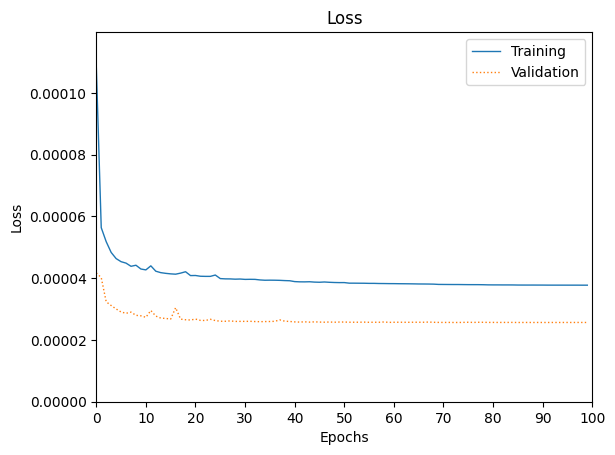

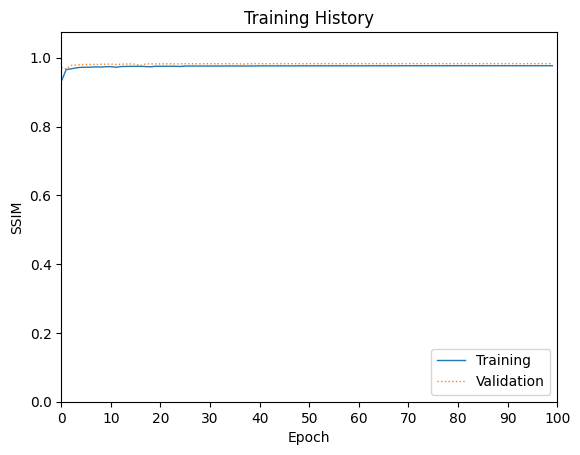

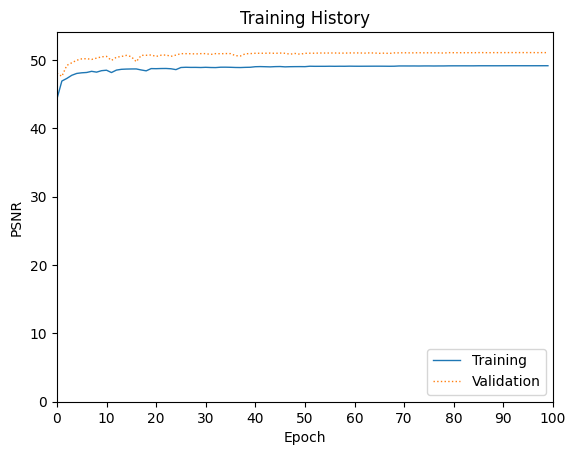

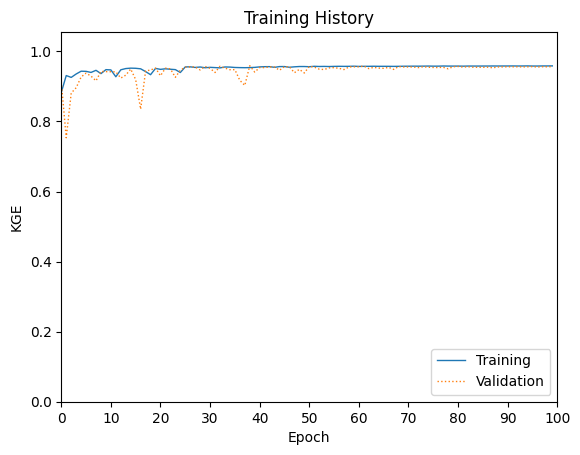

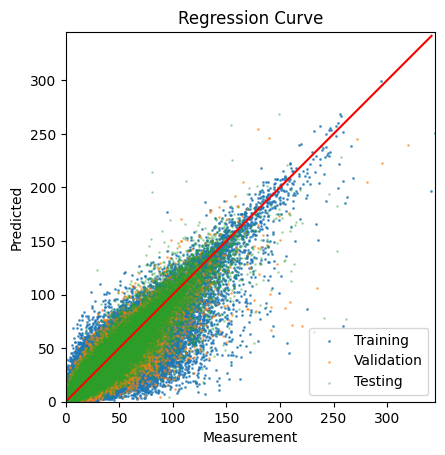

In [22]:
plt.figure()
plt.plot(history.history['loss'], label='Training', color='#1f77b4', linestyle='-', linewidth=1)
plt.plot(history.history['val_loss'], label='Validation', color='#ff7f0e', linestyle=':', linewidth=1)
plt.title("Loss", loc='center')
plt.xlabel("Epochs")
plt.xticks(np.arange(0,numEpochs+numEpochs/10,numEpochs/10))
plt.ylabel("Loss")
lossTrain   = max(history.history['loss'])
lossVal     = max(history.history['val_loss'])
maxvalue    = max(lossTrain, lossVal)
plt.yticks  = (np.arange(0,maxvalue+maxvalue/10, maxvalue/10))
plt.legend(loc="upper right")
plt.axis([0,numEpochs,0,maxvalue+maxvalue/10])
plt.savefig(ReportFolder + '/Graph/Loss.png')

plt.figure()
plt.plot(history.history[keys[1]], label='Training', color='#1f77b4', linestyle='-', linewidth=1)
plt.plot(history.history[keys[5]], label='Validation', color='#ff7f0e', linestyle=':', linewidth=1)
plt.title('Training History', loc='center')
plt.xlabel("Epoch")
plt.xticks(np.arange(0,numEpochs+numEpochs/10,numEpochs/10))
plt.ylabel(keys[1])
metricsTrain    = max(history.history[keys[1]])
metricsVal      = max(history.history[keys[3]])
maxvalue        = max(metricsTrain, metricsVal)
plt.yticks      = (np.arange(0,maxvalue+maxvalue/10, maxvalue/10))
plt.axis([0,numEpochs,0,maxvalue+maxvalue/10])
plt.legend(loc="lower right")
plt.savefig(ReportFolder + '/Graph/' + keys[1] +'.png')

plt.figure()
plt.plot(history.history[keys[2]], label='Training', color='#1f77b4', linestyle='-', linewidth=1)
plt.plot(history.history[keys[6]], label='Validation', color='#ff7f0e', linestyle=':', linewidth=1)
plt.title('Training History', loc='center')
plt.xlabel("Epoch")
plt.xticks(np.arange(0,numEpochs+numEpochs/10,numEpochs/10))
plt.ylabel(keys[2])
metricsTrain    = max(history.history[keys[2]])
metricsVal      = max(history.history[keys[5]])
maxvalue        = max(metricsTrain, metricsVal)
plt.yticks      = (np.arange(0,maxvalue+maxvalue/10, maxvalue/10))
plt.axis([0,numEpochs,0,maxvalue+maxvalue/10])
plt.legend(loc="lower right")
plt.savefig(ReportFolder + '/Graph/' + keys[2] +'.png')

plt.figure()
plt.plot(history.history[keys[3]], label='Training', color='#1f77b4', linestyle='-', linewidth=1)
plt.plot(history.history[keys[7]], label='Validation', color='#ff7f0e', linestyle=':', linewidth=1)
plt.title('Training History', loc='center')
plt.xlabel("Epoch")
plt.xticks(np.arange(0,numEpochs+numEpochs/10,numEpochs/10))
plt.ylabel(keys[3])
metricsTrain    = max(history.history[keys[3]])
metricsVal      = max(history.history[keys[7]])
maxvalue        = max(metricsTrain, metricsVal)
plt.yticks      = (np.arange(0,maxvalue+maxvalue/10, maxvalue/10))
plt.axis([0,numEpochs,0,maxvalue+maxvalue/10])
plt.legend(loc="lower right")
plt.savefig(ReportFolder + '/Graph/' + keys[3] +'.png')

# Create Regression Curve training -validaation
# maxVal = math.ceil(np.max([precipTrainOriginal, yTrainPreds]))
maxVal = roundDecimal(np.max([precipTrainOriginal, yTrainPreds]),1)
xNorm  = np.arange(0, maxVal, maxVal/100)
yNorm  = np.arange(0, maxVal, maxVal/100)

fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(precipTrainOriginal, yTrainPreds,label='Training', color='#1f77b4', s=1, alpha=0.7)
plt.scatter(precipValOriginal, yValPreds,label='Validation', color='#ff7f0e', s=1,alpha=0.5)
plt.scatter(precipTestOriginal, yTestPreds,label='Testing', color='#2ca02c', s=1,alpha=0.3)
plt.plot(xNorm, yNorm, color='red')
plt.title("Regression Curve", loc='center')
plt.xlabel("Measurement")
plt.ylabel("Predicted")
plt.axis([0,maxVal,0,maxVal])
plt.legend(loc="lower right")
ax.set_aspect('equal', adjustable='box')
plt.savefig(ReportFolder + '/Graph/CorrelationCurve.png')

## Evaluation Reports in Actual Value

In [23]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Convert the history.history dict to a pandas dataframe
hist_df = pd.DataFrame(history.history)

# Save history to csv
with open(fileNameHist, mode='w') as f:
    hist_df.to_csv(f)

print('REGRESSION REPORTS')

print('\n')
print('1. Root Mean Squared Error')
rmseTrain = tf.keras.metrics.RootMeanSquaredError()
rmseTrain.update_state(precipTrainOriginal,yTrainPreds)
print('RMSE Train: ' + str(rmseTrain.result().numpy()))

rmseVal = tf.keras.metrics.RootMeanSquaredError()
rmseVal.update_state(precipValOriginal,yValPreds)
print('RMSE Validation: ' + str(rmseVal.result().numpy()))

rmseTest = tf.keras.metrics.RootMeanSquaredError()
rmseTest.update_state(precipTestOriginal,yTestPreds)
print('RMSE Testing: ' + str(rmseTest.result().numpy()))

print('\n')
print('2. Cosine Similarity')
csTrain = tf.keras.metrics.CosineSimilarity()
csTrain.update_state(precipTrainOriginal,yTrainPreds)
print('Cosine Similarity Train: ' + str(csTrain.result().numpy()))

csVal = tf.keras.metrics.CosineSimilarity()
csVal.update_state(precipValOriginal,yValPreds)
print('Cosine Similarity Validation: ' + str(csVal.result().numpy()))

csTest = tf.keras.metrics.CosineSimilarity()
csTest.update_state(precipTestOriginal,yTestPreds)
print('Cosine Similarity Testing: ' + str(csTest.result().numpy()))

def to_numpy(arr):
    return arr.numpy() if hasattr(arr, "numpy") else arr    

yTrainPreds_np         = to_numpy(yTrainPreds)
yValPreds_np           = to_numpy(yValPreds)
yTestPreds_np          = to_numpy(yTestPreds)
precipTrainOriginal_np = to_numpy(precipTrainOriginal)
precipValOriginal_np   = to_numpy(precipValOriginal)
precipTestOriginal_np  = to_numpy(precipTestOriginal)

print('\n')
print('3.  Coefficient of Determination')
R2Train = r2_score(precipTrainOriginal_np.reshape(-1), yTrainPreds_np.reshape(-1))
print('R2 score Train: ', R2Train)

R2Val   = r2_score(precipValOriginal_np.reshape(-1),   yValPreds_np.reshape(-1))
print('R2 score Val: ', R2Val)

R2Test  = r2_score(precipTestOriginal_np.reshape(-1),  yTestPreds_np.reshape(-1))
print('R2 score Test: ', R2Test)

print('\n')
print('4. Mean Absolute Error')
maeTrain = tf.keras.metrics.MeanAbsoluteError()
maeTrain.update_state(precipTrainOriginal,yTrainPreds)
print('Mean Absolute Error Train: ' + str(maeTrain.result().numpy()))

maeVal = tf.keras.metrics.MeanAbsoluteError()
maeVal.update_state(precipValOriginal,yValPreds)
print('Mean Absolute Error Validation: ' + str(maeVal.result().numpy()))

maeTest = tf.keras.metrics.MeanAbsoluteError()
maeTest.update_state(precipTestOriginal,yTestPreds)
print('Mean Absolute Error Testing: ' + str(maeTest.result().numpy()))

print('\n')
print('5. Mean Squared Error')
mseTrain = tf.keras.metrics.MeanSquaredError()
mseTrain.update_state(precipTrainOriginal,yTrainPreds)
print('Mean Squared Error Train: ' + str(mseTrain.result().numpy()))

mseVal = tf.keras.metrics.MeanSquaredError()
mseVal.update_state(precipValOriginal,yValPreds)
print('Mean Squared Error Validation: ' + str(mseVal.result().numpy()))

mseTest = tf.keras.metrics.MeanSquaredError()
mseTest.update_state(precipTestOriginal,yTestPreds)
print('Mean Squared Error Testing: ' + str(mseTest.result().numpy()))

print('\n')
print('6. Mean Absolute Percentage Error')
mapeTrain = tf.keras.metrics.MeanAbsolutePercentageError()
mapeTrain.update_state(precipTrainOriginal,yTrainPreds)
print('Mean Absolute Percentage Error Train: ' + str(mapeTrain.result().numpy()))

mapeVal = tf.keras.metrics.MeanAbsolutePercentageError()
mapeVal.update_state(precipValOriginal,yValPreds)
print('Mean Absolute Percentage Error Validation: ' + str(mapeVal.result().numpy()))

mapeTest = tf.keras.metrics.MeanAbsolutePercentageError()
mapeTest.update_state(precipTestOriginal,yTestPreds)
print('Mean Absolute Percentage Error Testing: ' + str(mapeTest.result().numpy()))

print('\n')
print('7. Peak Signal-to-Noise Ratio (PSNR)')
psnrTrain = tf.image.psnr(precipTrainOriginal, yTrainPreds, max_val=500)
print('Peak Signal-to-Noise Ratio (PSNR) Train: ' + str(tf.reduce_mean(psnrTrain).numpy()))

psnrVal  = tf.image.psnr(precipValOriginal, yValPreds, max_val=500)
print('Peak Signal-to-Noise Ratio (PSNR) Validation: ' + str(tf.reduce_mean(psnrVal).numpy()))

psnrTest = tf.image.psnr(precipTestOriginal, yTestPreds, max_val=500)
print('Peak Signal-to-Noise Ratio (PSNR) Testing: ' + str(tf.reduce_mean(psnrTest).numpy()))

print('\n')
print('8. Structural Similarity Index (SSIM)')
ssimTrain = tf.image.ssim(precipTrainOriginal, yTrainPreds, max_val=500)
print('Structural Similarity Index (SSIM) Train: ' + str(tf.reduce_mean(ssimTrain).numpy()))

ssimVal = tf.image.ssim(precipValOriginal, yValPreds, max_val=500)
print('Structural Similarity Index (SSIM) Validation: ' + str(tf.reduce_mean(ssimVal).numpy()))

ssimTest = tf.image.ssim(precipTestOriginal, yTestPreds, max_val=500)
print('Structural Similarity Index (SSIM) Testing: ' + str(tf.reduce_mean(ssimTest).numpy()))

print('\n')
print('9. Kling-Gupta Efficiency (KGE)')
KGETrain = KGE(precipTrainOriginal_np, yTrainPreds_np)
print('KGE Train: ', KGETrain)

KGEVal = KGE(precipValOriginal_np, yValPreds_np)
print('KGE Validation: ', KGEVal)

KGETest = KGE(precipTestOriginal_np, yTestPreds_np)
print('KGE Testing: ', KGETest)

# Create hyperparameter setup and performance report
with open(fileNameReport, 'w') as f:
    f.write(
        'Model name             : {model_name} \n'.format(model_name = modelName) +        
        'Number of epochs       : {num_epochs} \n'.format(num_epochs = numEpochs) +
        'Batch size             : {batch_size} \n'.format(batch_size = batch_size) +        
        'Train dataset size     : {size} \n'.format(size = str(precipHighResTrain.shape)) +
        'Test dataset size      : {size} \n'.format(size = str(precipHighResTest.shape)) +
        'Val dataset size       : {size} \n'.format(size = str(precipHighResVal.shape)) +
        'Folder Reports         : {folder_reports} \n'.format(folder_reports = ReportFolder) +                    
        'Total training time    : {training_time} minutes \n'.format(training_time = diffTime) +      
        'RMSE Train             : {RMSE_Train} \n'.format(RMSE_Train = str(rmseTrain.result().numpy())) +
        'RMSE Val               : {RMSE_Val} \n'.format(RMSE_Val = str(rmseVal.result().numpy())) +
        'RMSE Test              : {RMSE_Test} \n'.format(RMSE_Test = str(rmseTest.result().numpy())) +
        'R2 score Train         : {R2_Train} \n'.format(R2_Train = str(R2Train)) +
        'R2 score Val           : {R2_Val} \n'.format(R2_Val = str(R2Val)) +
        'R2 score Test          : {R2_Test} \n'.format(R2_Test = str(R2Test)) +
        'Cosine Similarity Train: {CS_Train} \n'.format(CS_Train = str(csTrain.result().numpy())) +
        'Cosine Similarity Val  : {CS_Val} \n'.format(CS_Val = str(csVal.result().numpy())) +
        'Cosine Similarity Test : {CS_Test} \n'.format(CS_Test = str(csTest.result().numpy()))+
        'Mean Absolute Error Train: {MAE_Train} \n'.format(MAE_Train = str(maeTrain.result().numpy())) +
        'Mean Absolute Error Val  : {MAE_Val} \n'.format(MAE_Val = str(maeVal.result().numpy())) +
        'Mean Absolute Error Test : {MAE_Test} \n'.format(MAE_Test = str(maeTest.result().numpy()))+
        'Mean Absolute Percentage Error Train: {MAPE_Train} \n'.format(MAPE_Train = str(mapeTrain.result().numpy())) +
        'Mean Absolute Percentage Error Val  : {MAPE_Val} \n'.format(MAPE_Val = str(mapeVal.result().numpy())) +
        'Mean Absolute Percentage Error Test : {MAPE_Test} \n'.format(MAPE_Test = str(mapeTest.result().numpy()))+
        'Mean Squared Error Train: {MSE_Train} \n'.format(MSE_Train = str(mseTrain.result().numpy())) +
        'Mean Squared Error Val  : {MSE_Val} \n'.format(MSE_Val = str(mseVal.result().numpy())) +
        'Mean Squared Error Test : {MSE_Test} \n'.format(MSE_Test = str(mseTest.result().numpy())) +
        'Peak Signal-to-Noise Ratio Train: {PSNR_Train} \n'.format(PSNR_Train = str(tf.reduce_mean(psnrTrain).numpy())) +
        'Peak Signal-to-Noise Ratio Val  : {PSNR_Val} \n'.format(PSNR_Val = str(tf.reduce_mean(psnrVal).numpy())) +
        'Peak Signal-to-Noise Ratio Test : {PSNR_Test} \n'.format(PSNR_Test = str(tf.reduce_mean(psnrTest).numpy())) +
        'Structural Similarity Index Train  : {SSIM_Train} \n'.format(SSIM_Train = str(tf.reduce_mean(ssimTrain).numpy())) +
        'Structural Similarity Index Val    : {SSIM_Val} \n'.format(SSIM_Val = str(tf.reduce_mean(ssimVal).numpy())) +
        'Structural Similarity Index Test   : {SSIM_Test} \n'.format(SSIM_Test = str(tf.reduce_mean(ssimTest).numpy())) +
        'Kling-Gupta Efficiency Train: {KGE_Train} \n'.format(KGE_Train = str(KGETrain)) +
        'Kling-Gupta Efficiency Val  : {KGE_Val} \n'.format(KGE_Val = str(KGEVal)) +
        'Kling-Gupta Efficiency Test : {KGE_Test} \n'.format(KGE_Test = str(KGETest))
        )

REGRESSION REPORTS


1. Root Mean Squared Error
RMSE Train: 2.117816
RMSE Validation: 1.746718
RMSE Testing: 1.7106757


2. Cosine Similarity
Cosine Similarity Train: 0.8853855
Cosine Similarity Validation: 0.892497
Cosine Similarity Testing: 0.94031864


3.  Coefficient of Determination
R2 score Train:  0.944945752620697
R2 score Val:  0.9591686129570007
R2 score Test:  0.9673482179641724


4. Mean Absolute Error
Mean Absolute Error Train: 0.88310796
Mean Absolute Error Validation: 0.75268406
Mean Absolute Error Testing: 0.7278497


5. Mean Squared Error
Mean Squared Error Train: 4.485144
Mean Squared Error Validation: 3.051024
Mean Squared Error Testing: 2.9264116


6. Mean Absolute Percentage Error
Mean Absolute Percentage Error Train: 5086587.0
Mean Absolute Percentage Error Validation: 3900875.5
Mean Absolute Percentage Error Testing: 1119414.6


7. Peak Signal-to-Noise Ratio (PSNR)
Peak Signal-to-Noise Ratio (PSNR) Train: 52.38781
Peak Signal-to-Noise Ratio (PSNR) Validation: 54.

## Visualize the Comparison

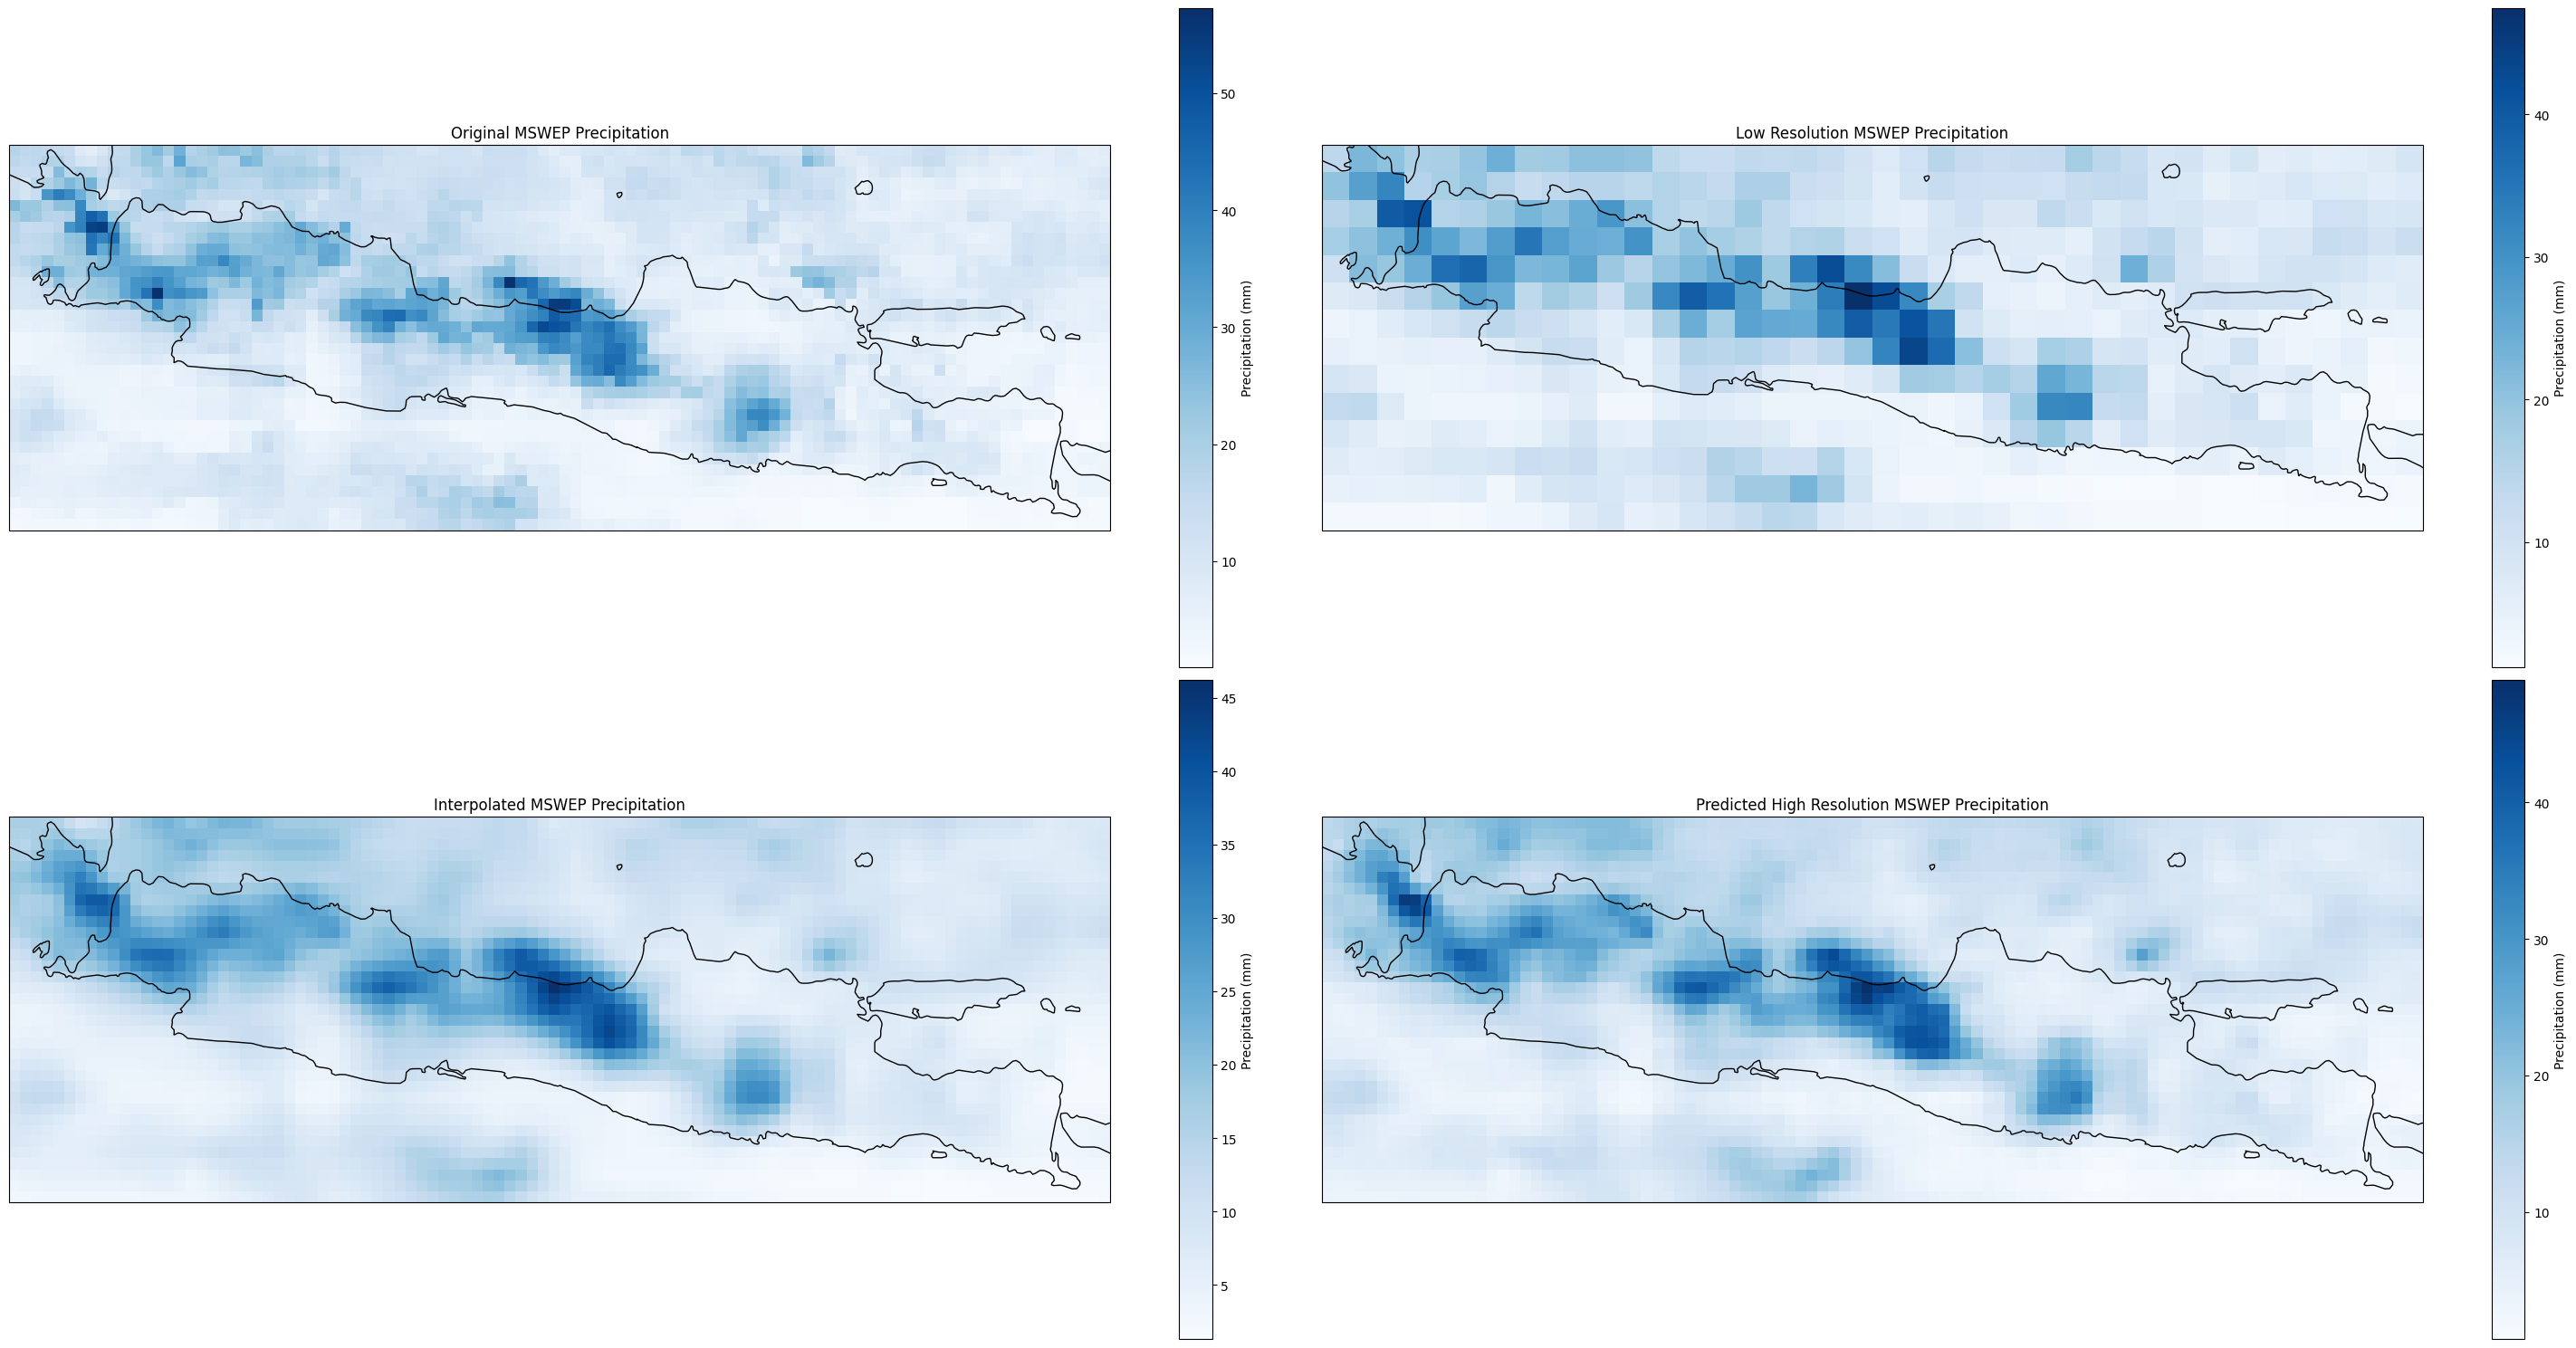

In [24]:
specificDate    = np.datetime64('2024-01-02')  # Replace with your target date

# Convert to XARRAY object
dsOriginal      = image2Xarray(precipTestOriginal[:,:,:,0], lonOriginal, latOriginal, timeOriginalTest)
dsLowRes        = image2Xarray(precipLowResTest[:,:,:,0], lonLowRes, latLowRes, timeLowResTest)
dsHighRes       = image2Xarray(precipHighResTest[:,:,:,0], lonHighRes, latHighRes, timeHighResTest)
dsPredicted     = image2Xarray(yTestPreds[:,:,:,0], lonHighRes, latHighRes, timeHighResTest)

# Extract precipitation data
precipOriginal  = selectPrecipitation(dsOriginal, specificDate)
precipLowRes    = selectPrecipitation(dsLowRes, specificDate)
precipHighRes   = selectPrecipitation(dsHighRes, specificDate)
precipPredict   = selectPrecipitation(dsPredicted, specificDate)

# Create figure with Cartopy projection
fig, ax = plt.subplots(2, 2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot precipitation data
precipOriginal.plot(ax=ax[0,0], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})
precipLowRes.plot(ax=ax[0,1], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})
precipHighRes.plot(ax=ax[1,0], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})
precipPredict.plot(ax=ax[1,1], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})

# Add coastlines, country borders, and gridlines
ax[0,0].coastlines()
ax[0,0].add_feature(cfeature.BORDERS, linestyle=':')
ax[0,0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[0,0].set_title("Original MSWEP Precipitation")

# Add coastlines, country borders, and gridlines
ax[0,1].coastlines()
ax[0,1].add_feature(cfeature.BORDERS, linestyle=':')
ax[0,1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[0,1].set_title("Low Resolution MSWEP Precipitation")

# Add coastlines, country borders, and gridlines
ax[1,0].coastlines()
ax[1,0].add_feature(cfeature.BORDERS, linestyle=':')
ax[1,0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[1,0].set_title("Interpolated MSWEP Precipitation")

# Add coastlines, country borders, and gridlines
ax[1,1].coastlines()
ax[1,1].add_feature(cfeature.BORDERS, linestyle=':')
ax[1,1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[1,1].set_title("Predicted High Resolution MSWEP Precipitation")

# Show the images
plt.tight_layout()
plt.savefig(ReportFolder + '/Graph/Example.png')
plt.show()

## Testing with NEX GDDP CMIP6

In [25]:
from tensorflow.keras.models import load_model
from myLibrary import inversTransform

with tf.device('/CPU:0'):
    # Reload model (since session was reset)
    modelEDSR = load_model(h5modelSavePath, custom_objects={"SSIM": SSIM, "PSNR": PSNR, "RSquare": RSquare, "KGE": KGE})

In [29]:
gcm_path = pathNow / "Datasets" / "Ina_NEX-GDDP-CMIP6-Mahasiswa" / "Adit"
example_file = gcm_path / "ina_EC-Earth3_ssp245_2024_pr.nc"
ds = xr.open_dataset(example_file)
print(ds)

<xarray.Dataset> Size: 20MB
Dimensions:  (time: 366, lon: 190, lat: 72)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2024-01-01T12:00:00 ... 2024-12-31T12:...
  * lon      (lon) float64 2kB 94.62 94.88 95.12 95.38 ... 141.4 141.6 141.9
  * lat      (lat) float64 576B -10.88 -10.62 -10.38 ... 6.375 6.625 6.875
Data variables:
    pr       (time, lat, lon) float32 20MB ...
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.1.1 (https://mpim...
    Conventions:           CF-1.7
    source:                BCSD
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    ...                    ...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       EC-Earth3
    cmip6_institution_id:  EC-Earth-Consortium
    cmip6_licen

In [30]:
print(ds["pr"])
print(ds["pr"].mean().item(), ds["pr"].std().item())

<xarray.DataArray 'pr' (time: 366, lat: 72, lon: 190)> Size: 20MB
[5006880 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 3kB 2024-01-01T12:00:00 ... 2024-12-31T12:...
  * lon      (lon) float64 2kB 94.62 94.88 95.12 95.38 ... 141.4 141.6 141.9
  * lat      (lat) float64 576B -10.88 -10.62 -10.38 ... 6.375 6.625 6.875
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    units:          kg m-2 s-1
    comment:        includes both liquid and solid phases
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
7.009378896327689e-05 8.357844490092248e-05


In [31]:
print(ds["pr"].attrs.get("units", "unknown"))

kg m-2 s-1


In [32]:
precip = ds["pr"] * 86400  # kg/m²/s to mm/day

In [33]:
precip_cropped = precip.interp(lat=latLowRes, lon=lonLowRes, method="nearest")
print(precip_cropped.mean().item(), precip_cropped.std().item())

4.125704076793077 6.603087395867675


In [34]:
gcm_input = precip_cropped.values.astype(np.float32)
gcm_input = np.where(np.isnan(gcm_input), 0, gcm_input)
gcm_input = gcm_input[..., np.newaxis]  # shape: (time, 14, 40, 1)

In [35]:
scaler              = MinMaxScaler()
scaler.scale_       = scale_ 
scaler.min_         = min_
scaler.data_min_    = data_min_
scaler.data_max_    = data_max_
scaler.feature_range = feature_range

gcm_input_normalized = np.zeros_like(gcm_input)

for i in range(gcm_input.shape[0]):
    img = gcm_input[i].reshape(-1, 1)
    gcm_input_normalized[i] = scaler.transform(img).reshape(14, 40, 1)

In [36]:
with tf.device('/CPU:0'):
    yGcmPred = modelEDSR.predict(gcm_input_normalized, batch_size=64)

6/6 [==============================] - 2s 342ms/step


In [37]:
extentLowRes  = [lonLowRes.min(), lonLowRes.max(), latLowRes.min(), latLowRes.max()]
extentHighRes = [lonHighRes.min(), lonHighRes.max(), latHighRes.min(), latHighRes.max()]

In [38]:
with tf.device('/CPU:0'):
    # Recreate the same scaler
    scaler = MinMaxScaler()
    scaler.scale_ = scale_
    scaler.min_ = min_
    scaler.data_min_ = data_min_
    scaler.data_max_ = data_max_
    scaler.feature_range = feature_range

    # Inverse the normalized model output
    yGcmPred = inversTransform(scaler, yGcmPred)

    # Set negatives to zero (rain can’t be negative)
    yGcmPred = np.where(yGcmPred >= 0, yGcmPred, 0)

In [39]:
# # Choose specific day index, e.g., 123rd day
# index = 100

# # Access input and predicted data for that day
# gcm_day = gcm_input[index, ..., 0]      # raw GCM (0.25°)
# pred_day = yGcmPred[index, ..., 0]      # model output (0.1°)

# print(f"Date index: {index}, Min/Max GCM: {gcm_day.min()} / {gcm_day.max()}")

# fig, ax = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot GCM
# img1 = ax[0].imshow(
#     gcm_day,
#     extent=[lonLowRes.min(), lonLowRes.max(), latLowRes.min(), latLowRes.max()],
#     origin="lower",
#     cmap="Blues"
# )
# ax[0].coastlines(resolution="10m", color="black")
# ax[0].add_feature(cfeature.BORDERS, linestyle=':')
# ax[0].set_title("Raw GCM (0.25°)")
# fig.colorbar(img1, ax=ax[0], shrink=0.7)

# # Plot Prediction
# img2 = ax[1].imshow(
#     pred_day,
#     extent=[lonHighRes.min(), lonHighRes.max(), latHighRes.min(), latHighRes.max()],
#     origin="lower",
#     cmap="Blues"
# )
# ax[1].coastlines(resolution="10m", color="black")
# ax[1].add_feature(cfeature.BORDERS, linestyle=':')
# ax[1].set_title("Downscaled GCM (0.1°)")
# fig.colorbar(img2, ax=ax[1], shrink=0.7)

# plt.tight_layout()
# plt.show()


In [40]:
def get_edges_from_centers(centers):
    step = np.diff(centers).mean()
    edges = np.concatenate([
        [centers[0] - step / 2],
        centers + step / 2
    ])
    return edges

In [41]:
latLowRes_edges = get_edges_from_centers(latLowRes)
lonLowRes_edges = get_edges_from_centers(lonLowRes)

latHighRes_edges = get_edges_from_centers(latHighRes)
lonHighRes_edges = get_edges_from_centers(lonHighRes)

In [42]:
gcm_time = precip_cropped.time.values  # or: ds['time'].values if from full .nc
print(gcm_input.shape)     # Should be (time, lat, lon, 1)
print(yGcmPred.shape)      # Should be (time, lat, lon, 1)

(366, 14, 40, 1)
(366, 35, 100, 1)


In [43]:
dsGcmOriginal  = image2Xarray(gcm_input[..., 0], lonLowRes, latLowRes, gcm_time)
dsGcmDownscaled = image2Xarray(yGcmPred[..., 0], lonHighRes, latHighRes, gcm_time)

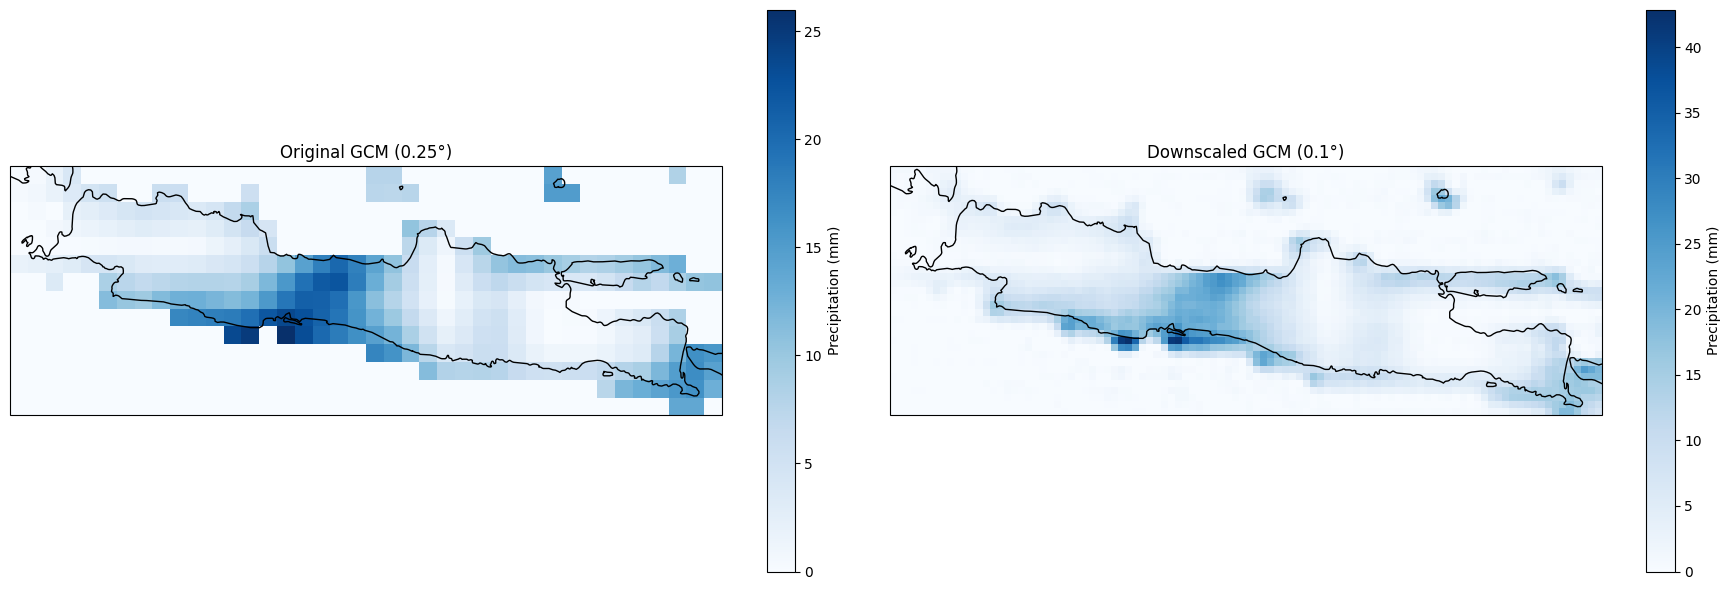

In [ ]:
specificDate = np.datetime64('2024-05-01')  # Adjust to match available range

precipGcmOrig      = selectPrecipitation(dsGcmOriginal, specificDate)
precipGcmDownscaled = selectPrecipitation(dsGcmDownscaled, specificDate)

fig, ax = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Raw GCM
precipGcmOrig.plot(
    ax=ax[0], cmap='Blues', transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Precipitation (mm)'}
)
ax[0].coastlines()
ax[0].add_feature(cfeature.BORDERS, linestyle=':')
ax[0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[0].set_title("Original GCM (0.25°): 2024-05-01")

# Downscaled
precipGcmDownscaled.plot(
    ax=ax[1], cmap='Blues', transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Precipitation (mm)'}
)
ax[1].coastlines()
ax[1].add_feature(cfeature.BORDERS, linestyle=':')
ax[1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[1].set_title("Downscaled GCM (0.1°): 2024-05-01")

# Save and show
plt.tight_layout()
plt.savefig(ReportFolder + '/Graph/GCM_Comparison.png')
plt.show()


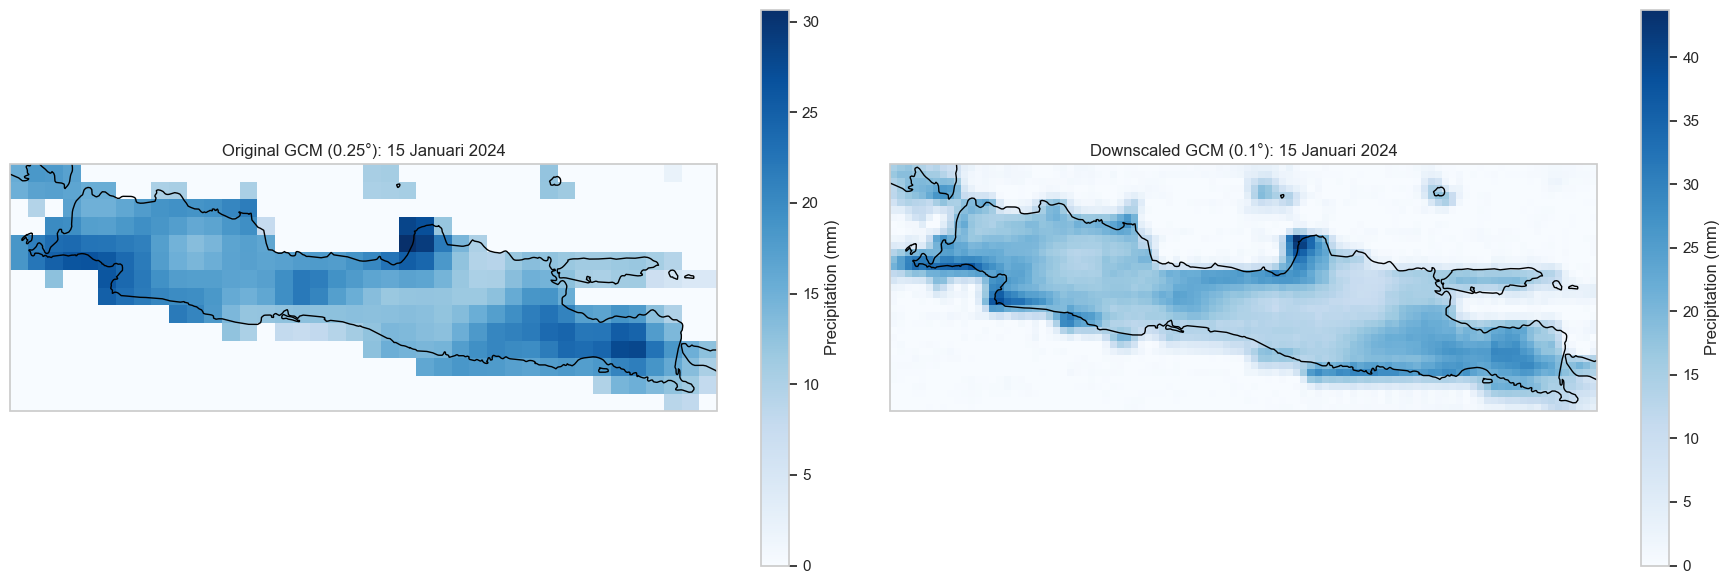

In [163]:
specificDate = np.datetime64('2024-01-15')  # Adjust to match available range

precipGcmOrig      = selectPrecipitation(dsGcmOriginal, specificDate)
precipGcmDownscaled = selectPrecipitation(dsGcmDownscaled, specificDate)

fig, ax = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Raw GCM
precipGcmOrig.plot(
    ax=ax[0], cmap='Blues', transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Precipitation (mm)'}
)
ax[0].coastlines()
ax[0].add_feature(cfeature.BORDERS, linestyle=':')
ax[0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[0].set_title("Original GCM (0.25°): 15 Januari 2024")

# Downscaled
precipGcmDownscaled.plot(
    ax=ax[1], cmap='Blues', transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Precipitation (mm)'}
)
ax[1].coastlines()
ax[1].add_feature(cfeature.BORDERS, linestyle=':')
ax[1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[1].set_title("Downscaled GCM (0.1°): 15 Januari 2024")

# Save and show
plt.tight_layout()
plt.savefig(ReportFolder + '/Graph/GCM_Comparison.png')
plt.show()


In [58]:
print("Min-Max Precipitation (Original)  :", precipTestOriginal.min(), "-", precipTestOriginal.max())
print("Min-Max Precipitation (Low Res)   :", precipLowResTest.min(), "-", precipLowResTest.max())
print("Min-Max Precipitation (High Res)  :", precipHighResTest.min(), "-", precipHighResTest.max())
print("Min-Max Precipitation (Prediction):", yTestPreds.min(), "-", yTestPreds.max())

Min-Max Precipitation (Original)  : tf.Tensor(0.0, shape=(), dtype=float32) - tf.Tensor(261.32812, shape=(), dtype=float32)
Min-Max Precipitation (Low Res)   : tf.Tensor(0.0, shape=(), dtype=float64) - tf.Tensor(224.98679275355272, shape=(), dtype=float64)
Min-Max Precipitation (High Res)  : tf.Tensor(-8.88056446946614e-16, shape=(), dtype=float64) - tf.Tensor(196.71333280516885, shape=(), dtype=float64)
Min-Max Precipitation (Prediction): 0.0 - 268.21265


In [59]:
# Gabungkan seluruh data jika belum ada
precipOriginalAll = np.concatenate([
    precipTrainOriginal[:, :, :, 0],
    precipValOriginal[:, :, :, 0],
    precipTestOriginal[:, :, :, 0]
], axis=0)

precipHighResAll = np.concatenate([
    precipHighResTrain[:, :, :, 0],
    precipHighResVal[:, :, :, 0],
    precipHighResTest[:, :, :, 0]
], axis=0)

# Sesuaikan yTestPreds shape jika perlu (asumsinya sudah hasil akhir)
# Jika yTestPreds hanya berisi data test, tambahkan juga prediksi train & val jika ingin 1 tahun penuh
precipPredictAll = np.concatenate([
    yTrainPreds[:, :, :, 0],
    yValPreds[:, :, :, 0],
    yTestPreds[:, :, :, 0]
], axis=0)

# Waktu gabungan
timeAll = np.concatenate([timeOriginalTrain, timeOriginalVal, timeOriginalTest])

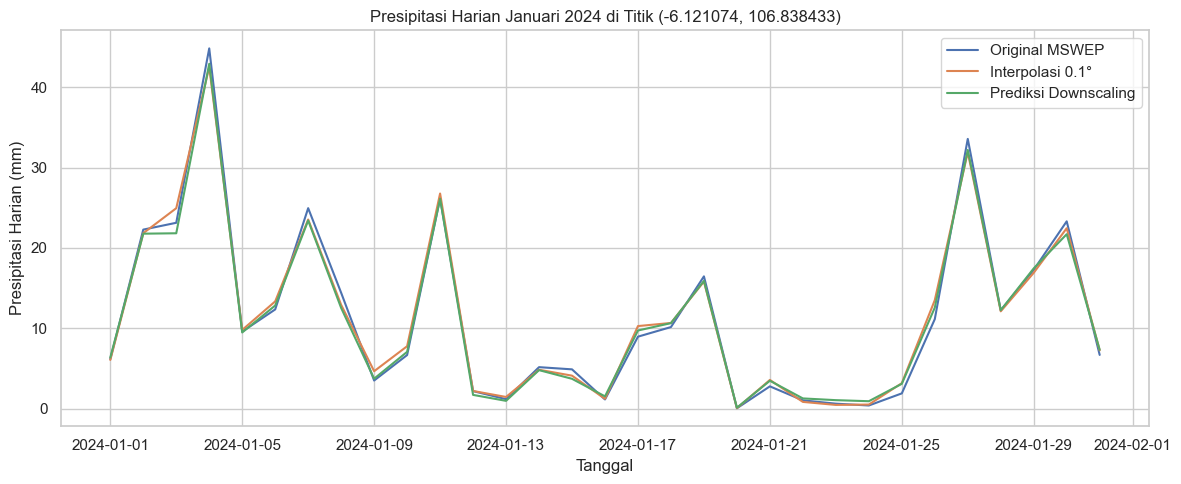

In [ ]:
# Koordinat target
target_lat = -6.121074
target_lon = 106.838433

# Cari indeks terdekat dari lat dan lon
lat_idx = np.abs(latOriginal - target_lat).argmin()
lon_idx = np.abs(lonOriginal - target_lon).argmin()

# Ambil data presipitasi di titik itu untuk semua dataset
seriesOriginal   = precipOriginalAll[:, lat_idx, lon_idx]
seriesHighRes    = precipHighResAll[:, lat_idx, lon_idx]
seriesPredicted  = precipPredictAll[:, lat_idx, lon_idx]

# Buat DataFrame untuk plotting
df_point = pd.DataFrame({
    'Tanggal': pd.to_datetime(timeAll),
    'Original MSWEP': seriesOriginal,
    'Interpolasi 0.1°': seriesHighRes,
    'Prediksi Model': seriesPredicted
})

# Filter hanya Januari 2024
df_point_jan = df_point[df_point['Tanggal'].dt.month == 1]
df_point_jan = df_point_jan[df_point_jan['Tanggal'].dt.year == 2024]

# Plot
plt.figure(figsize=(12,5))
plt.plot(df_point_jan['Tanggal'], df_point_jan['Original MSWEP'], label='Original MSWEP')
plt.plot(df_point_jan['Tanggal'], df_point_jan['Interpolasi 0.1°'], label='Interpolasi 0.1°')
plt.plot(df_point_jan['Tanggal'], df_point_jan['Prediksi Model'], label='Prediksi Downscaling')
plt.xlabel("Tanggal")
plt.ylabel("Presipitasi Harian (mm/hari)")
plt.title(f"Presipitasi Harian Januari 2024 di Titik ({target_lat}, {target_lon})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

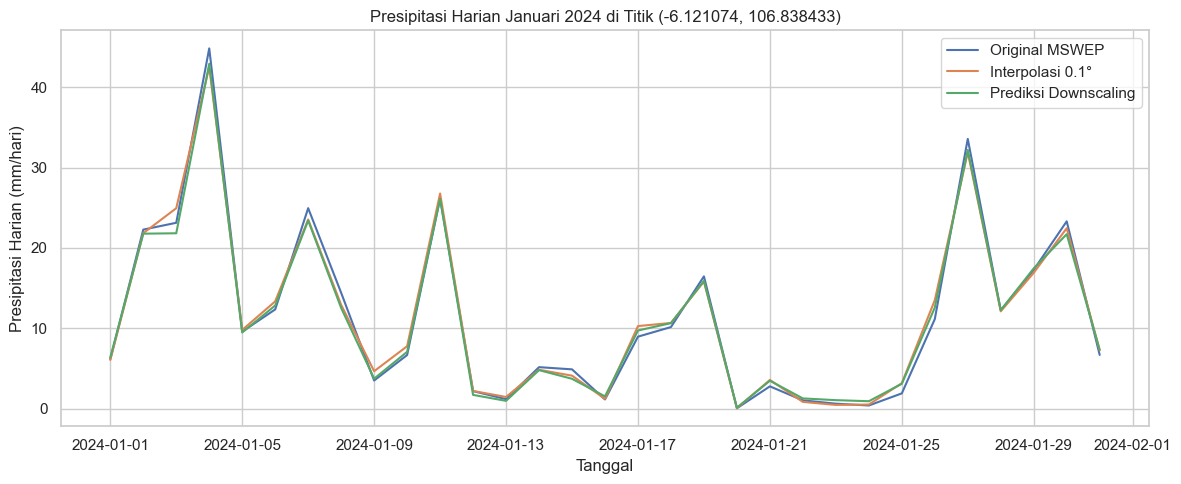

In [129]:
# Koordinat target
target_lat = -6.121074
target_lon = 106.838433

# Cari indeks terdekat dari lat dan lon
lat_idx = np.abs(latOriginal - target_lat).argmin()
lon_idx = np.abs(lonOriginal - target_lon).argmin()

# Ambil data presipitasi di titik itu untuk semua dataset
seriesOriginal   = precipOriginalAll[:, lat_idx, lon_idx]
seriesHighRes    = precipHighResAll[:, lat_idx, lon_idx]
seriesPredicted  = precipPredictAll[:, lat_idx, lon_idx]

# Buat DataFrame untuk plotting
df_point = pd.DataFrame({
    'Tanggal': pd.to_datetime(timeAll),
    'Original MSWEP': seriesOriginal,
    'Interpolasi 0.1°': seriesHighRes,
    'Prediksi Model': seriesPredicted
})

# Filter hanya Januari 2024
df_point_jan = df_point[df_point['Tanggal'].dt.month == 1]
df_point_jan = df_point_jan[df_point_jan['Tanggal'].dt.year == 2024]

# Plot
plt.figure(figsize=(12,5))
plt.plot(df_point_jan['Tanggal'], df_point_jan['Original MSWEP'], label='Original MSWEP')
plt.plot(df_point_jan['Tanggal'], df_point_jan['Interpolasi 0.1°'], label='Interpolasi 0.1°')
plt.plot(df_point_jan['Tanggal'], df_point_jan['Prediksi Model'], label='Prediksi Downscaling')
plt.xlabel("Tanggal")
plt.ylabel("Presipitasi Harian (mm/hari)")
plt.title(f"Presipitasi Harian Januari 2024 di Titik ({target_lat}, {target_lon})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

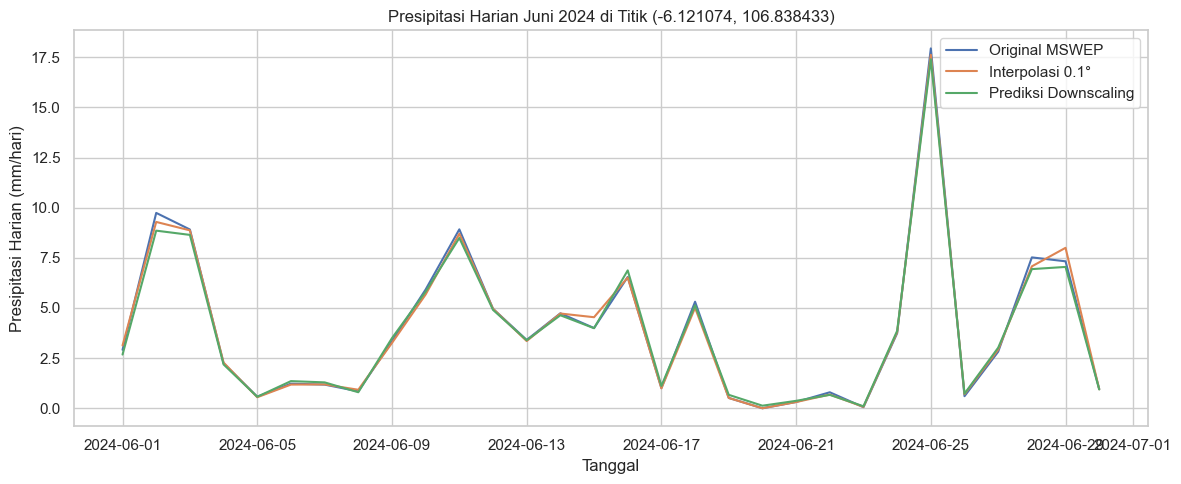

In [130]:
# Koordinat target
target_lat = -6.121074
target_lon = 106.838433

# Cari indeks terdekat dari lat dan lon
lat_idx = np.abs(latOriginal - target_lat).argmin()
lon_idx = np.abs(lonOriginal - target_lon).argmin()

# Ambil data presipitasi di titik itu untuk semua dataset
seriesOriginal   = precipOriginalAll[:, lat_idx, lon_idx]
seriesHighRes    = precipHighResAll[:, lat_idx, lon_idx]
seriesPredicted  = precipPredictAll[:, lat_idx, lon_idx]

# Buat DataFrame untuk plotting
df_point = pd.DataFrame({
    'Tanggal': pd.to_datetime(timeAll),
    'Original MSWEP': seriesOriginal,
    'Interpolasi 0.1°': seriesHighRes,
    'Prediksi Model': seriesPredicted
})

# Filter hanya Januari 2024
df_point_jan = df_point[df_point['Tanggal'].dt.month == 6]
df_point_jan = df_point_jan[df_point_jan['Tanggal'].dt.year == 2024]

# Plot
plt.figure(figsize=(12,5))
plt.plot(df_point_jan['Tanggal'], df_point_jan['Original MSWEP'], label='Original MSWEP')
plt.plot(df_point_jan['Tanggal'], df_point_jan['Interpolasi 0.1°'], label='Interpolasi 0.1°')
plt.plot(df_point_jan['Tanggal'], df_point_jan['Prediksi Model'], label='Prediksi Downscaling')
plt.xlabel("Tanggal")
plt.ylabel("Presipitasi Harian (mm/hari)")
plt.title(f"Presipitasi Harian Juni 2024 di Titik ({target_lat}, {target_lon})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\rifqi\AppData\Local\Temp\ipykernel_10260\4143793120.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


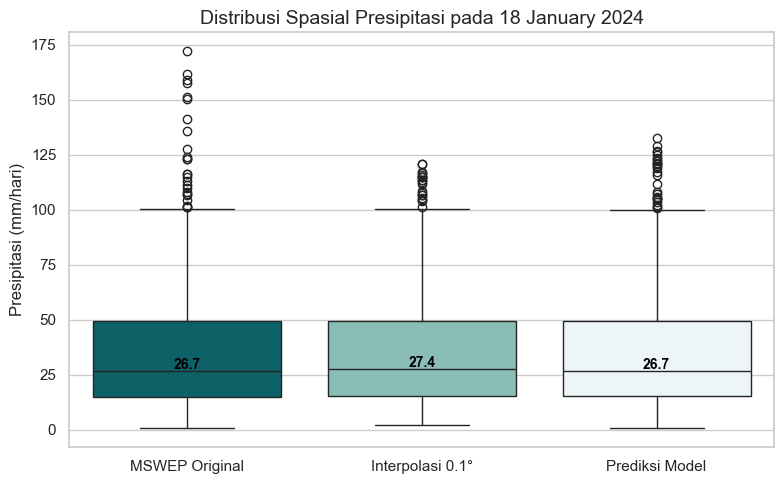

In [155]:
# Konversi timeAll ke datetime64[ns] jika belum
timeAll_ns = pd.to_datetime(timeAll).to_numpy()

# Target tanggal
target_date = np.datetime64('2024-01-18')

# Cari indeks tanggal terdekat
date_idx = np.abs(timeAll_ns - target_date).argmin()
actual_date = timeAll_ns[date_idx]  # tanggal asli di indeks tersebut

data_ori    = precipOriginalAll[date_idx, :, :].flatten()
data_interp = precipHighResAll[date_idx, :, :].flatten()
data_pred   = precipPredictAll[date_idx, :, :].flatten()

# Gabung ke DataFrame
df_box = pd.DataFrame({
    'MSWEP Original': data_ori,
    'Interpolasi 0.1°': data_interp,
    'Prediksi Model': data_pred
})

df_long = df_box.melt(var_name='Sumber', value_name='Presipitasi')

# Styling
sns.set(style="whitegrid")

# Plot dengan palette warna khusus
plt.figure(figsize=(8,5))
ax = sns.boxplot(
    data=df_long, x='Sumber', y='Presipitasi',
    palette=['#006d77', '#83c5be', '#edf6f9']  # Biru, oranye, hijau
)

# Tambahkan nilai median ke atas box
medians = df_box.median()
for i, median in enumerate(medians):
    ax.text(i, median + 1, f'{median:.1f}', horizontalalignment='center', size=10, color='black', weight='bold')

# Judul dan label
plt.title(f"Distribusi Spasial Presipitasi pada {pd.to_datetime(actual_date).strftime('%d %B %Y')}", fontsize=14)
plt.ylabel("Presipitasi (mm/hari)", fontsize=12)
plt.xlabel("", fontsize=12)
plt.tight_layout()
plt.show()

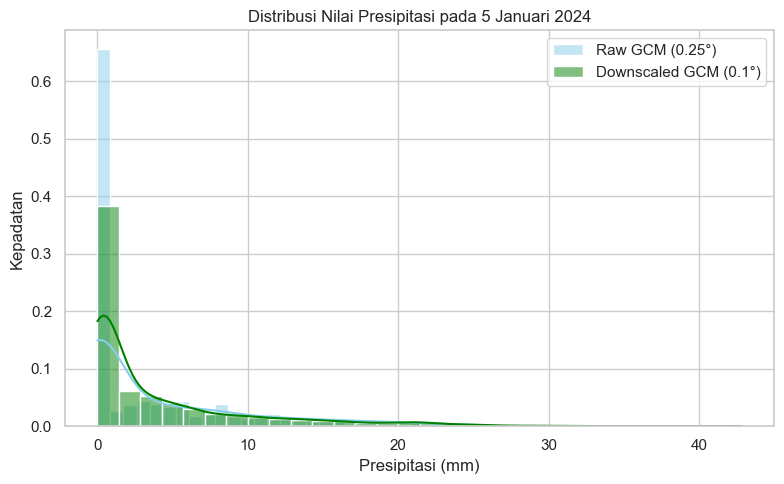

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(precipGcmOrig.values.flatten(), bins=30, label='Raw GCM (0.25°)', color='skyblue', stat='density', kde=True)
sns.histplot(precipGcmDownscaled.values.flatten(), bins=30, label='Downscaled GCM (0.1°)', color='green', stat='density', kde=True)
plt.xlabel("Presipitasi (mm)")
plt.ylabel("Kepadatan")
plt.title("Distribusi Nilai Presipitasi pada 5 Januari 2024")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

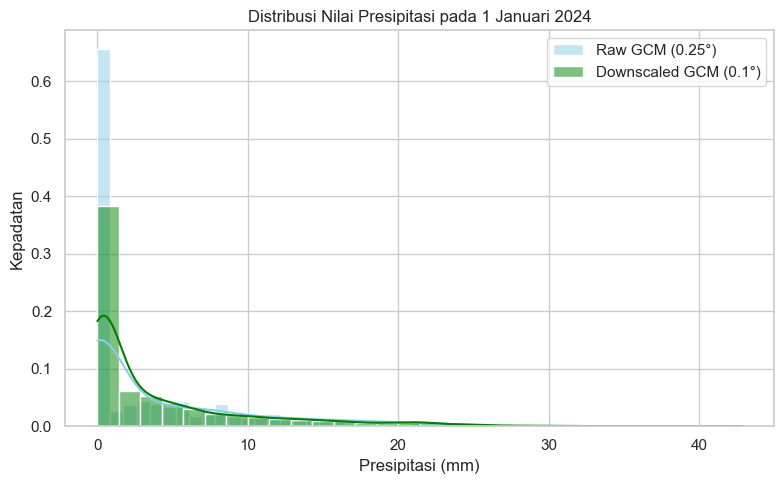

In [128]:
# Konversi timeAll ke datetime64[ns] jika belum
timeAll_ns = pd.to_datetime(timeAll).to_numpy()

# Target tanggal
target_date = np.datetime64('2024-01-01')

# Cari indeks tanggal terdekat
date_idx = np.abs(timeAll_ns - target_date).argmin()
actual_date = timeAll_ns[date_idx]  # tanggal asli di indeks tersebut

data_ori    = precipOriginalAll[date_idx, :, :].flatten()
data_interp = precipHighResAll[date_idx, :, :].flatten()
data_pred   = precipPredictAll[date_idx, :, :].flatten()

# Gabung ke DataFrame
df_box = pd.DataFrame({
    'MSWEP Original': data_ori,
    'Interpolasi 0.1°': data_interp,
    'Prediksi Model': data_pred
})

df_long = df_box.melt(var_name='Sumber', value_name='Presipitasi')

# Styling
sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
sns.histplot(precipGcmOrig.values.flatten(), bins=30, label='Raw GCM (0.25°)', color='skyblue', stat='density', kde=True)
sns.histplot(precipGcmDownscaled.values.flatten(), bins=30, label='Downscaled GCM (0.1°)', color='green', stat='density', kde=True)
plt.xlabel("Presipitasi (mm)")
plt.ylabel("Kepadatan")
plt.title("Distribusi Nilai Presipitasi pada 1 Januari 2024")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

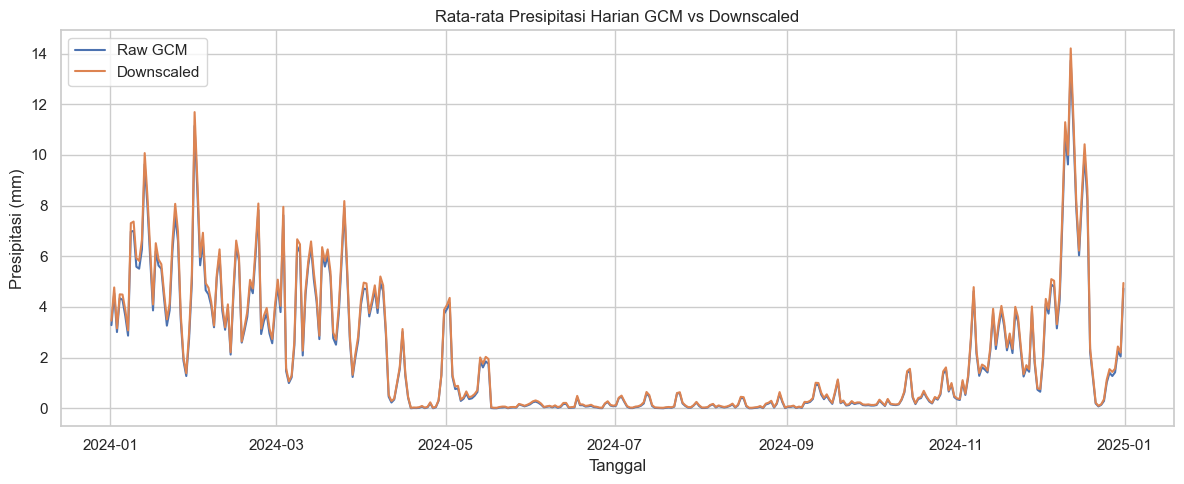

In [68]:
# Asumsikan dsGcmOriginal dan dsGcmDownscaled memiliki dimensi 'time'
meanGcmRaw        = dsGcmOriginal['precipitation'].mean(dim=('lat', 'lon'))
meanGcmDownscaled = dsGcmDownscaled['precipitation'].mean(dim=('lat', 'lon'))

plt.figure(figsize=(12,5))
plt.plot(meanGcmRaw['time'], meanGcmRaw, label='Raw GCM')
plt.plot(meanGcmDownscaled['time'], meanGcmDownscaled, label='Downscaled')
plt.title("Rata-rata Presipitasi Harian GCM vs Downscaled")
plt.ylabel("Presipitasi (mm)")
plt.xlabel("Tanggal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
print(precipTrainOriginal.shape)
print(precipLowResTrain.shape)
print(precipHighResTrain.shape)
print(yGcmPred.shape)

(5113, 35, 100, 1)
(5113, 14, 40, 1)
(5113, 35, 100, 1)
(366, 35, 100, 1)


## Evaluasi ST2172

In [119]:
import datetime

# STEP 1: Load dan filter data stasiun
df_sta = pd.read_excel("STA2172_2023-2024.xlsx")
df_sta['Date'] = pd.to_datetime(df_sta['Date'])

# Ambil hanya jam 23:59:00 (nilai akhir harian)
df_sta = df_sta[df_sta['Date'].dt.time == datetime.time(23, 59)]

# Ambil hanya tahun 2024
df_sta = df_sta[df_sta['Date'].dt.year == 2024]

# Floor agar formatnya cocok untuk merge
df_sta['Date'] = df_sta['Date'].dt.floor('D')

In [120]:
# Buat df_mswep seperti sebelumnya
df_mswep = pd.DataFrame({
    'Date': pd.to_datetime(timeOriginalTest),
    'MSWEP': np.squeeze(precipTestOriginal[:, lat_idx, lon_idx])
})
df_mswep = df_mswep[df_mswep['Date'].dt.year == 2024]
df_mswep['Date'] = df_mswep['Date'].dt.floor('D')

# Merge ulang
df_compare = pd.merge(df_sta, df_mswep, on='Date')
print(df_compare['Date'].value_counts().head())

Date
2024-01-01    1
2024-08-20    1
2024-09-09    1
2024-09-08    1
2024-09-07    1
Name: count, dtype: int64


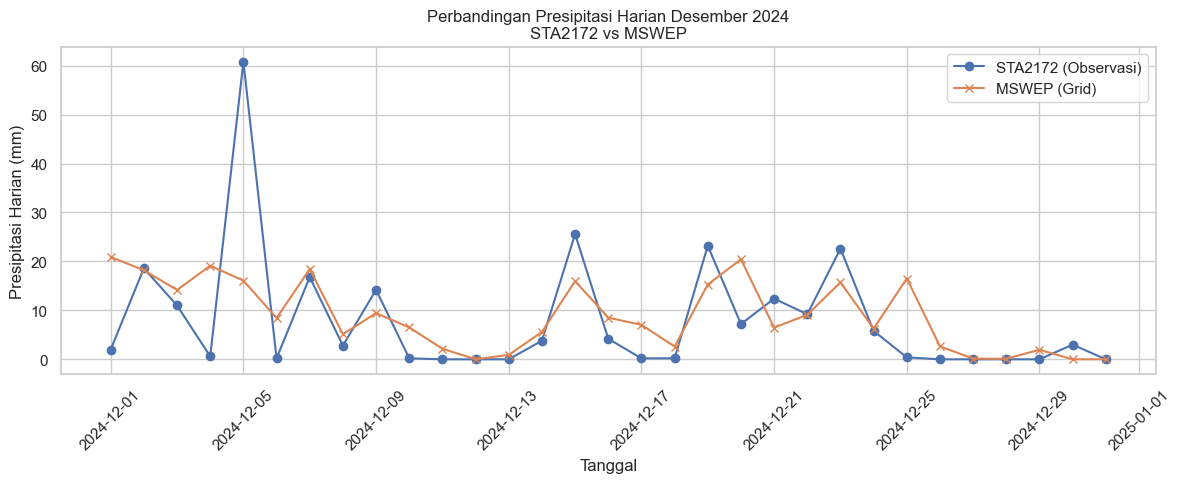

In [123]:
# Filter hanya untuk bulan Januari 2024
df_jan = df_compare[(df_compare['Date'].dt.year == 2024) & (df_compare['Date'].dt.month == 12)]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_jan['Date'], df_jan['rr'], label='STA2172 (Observasi)', marker='o')
plt.plot(df_jan['Date'], df_jan['MSWEP'], label='MSWEP (Grid)', marker='x')
plt.xlabel("Tanggal")
plt.ylabel("Presipitasi Harian (mm)")
plt.title("Perbandingan Presipitasi Harian Desember 2024\nSTA2172 vs MSWEP")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

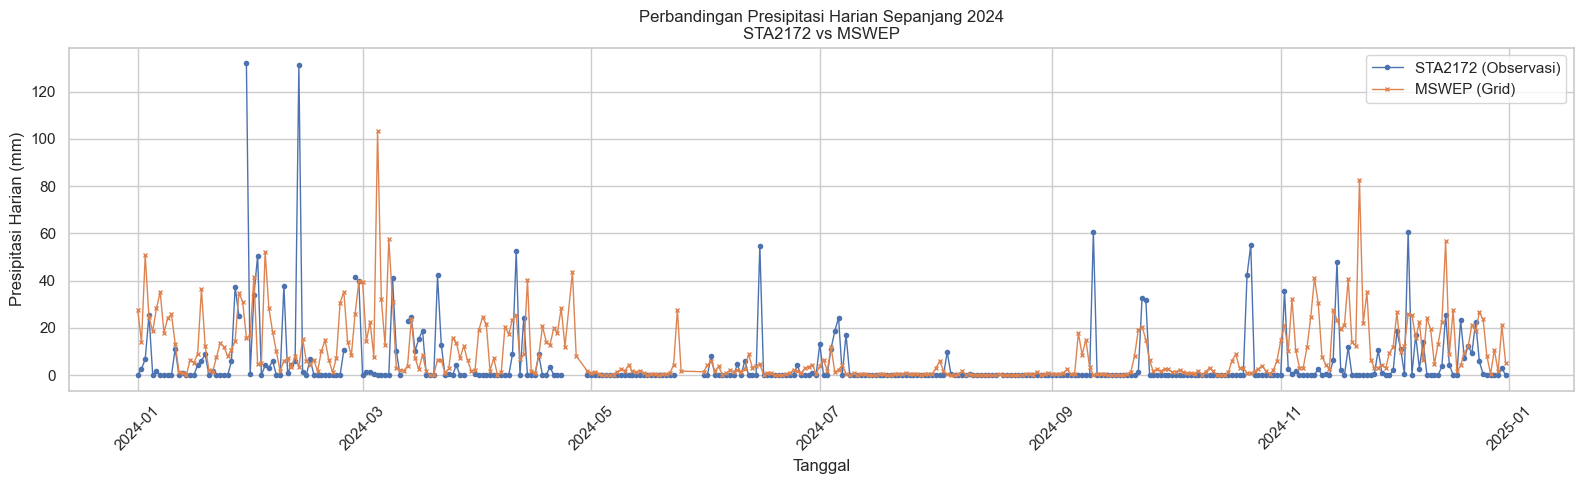

In [82]:
plt.figure(figsize=(16, 5))
plt.plot(df_compare['Date'], df_compare['rr'], label='STA2172 (Observasi)', marker='o', markersize=3, linewidth=1)
plt.plot(df_compare['Date'], df_compare['MSWEP'], label='MSWEP (Grid)', marker='x', markersize=3, linewidth=1)
plt.xlabel("Tanggal")
plt.ylabel("Presipitasi Harian (mm)")
plt.title("Perbandingan Presipitasi Harian Sepanjang 2024\nSTA2172 vs MSWEP")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
max_precip = df_compare['MSWEP'].max()
print(f"Nilai maksimum presipitasi MSWEP selama 2024: {max_precip:.2f} mm")

Nilai maksimum presipitasi MSWEP selama 2024: 103.49 mm
